### Test sklearn self training

In [140]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.semi_supervised import SelfTrainingClassifier
import pandas as pd
import os

### Script used to compute features matrix

In [ ]:
import os
import polars as pl
import numpy as np
from datetime import datetime
import logging
from typing import Dict, List, Tuple
import joblib
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, precision_score, recall_score,
    roc_auc_score
)
import xgboost as xgb
from lightgbm import LGBMClassifier

# Configure Polars for memory usage
pl.Config.set_streaming_chunk_size(1_000_000)
pl.Config.set_fmt_str_lengths(50)

class LazyDatasetLoader:
    """Memory-efficient dataset loader with checkpoint-based FID filtering"""
    
    def __init__(self, data_path: str, checkpoint_dir: str, debug_mode: bool = True, sample_size: int = 500_000):
        self.data_path = data_path
        self.checkpoint_dir = checkpoint_dir
        self._cached_dataset = None
        self._cached_name = None
        self.debug_mode = debug_mode
        self.sample_size = sample_size
        self.base_fids = None


    def set_base_fids(self, fids):
        """Set base FIDs to maintain consistent filtering"""
        self.base_fids = fids
        print(f"Set base FIDs: {len(fids)} records")
        
        
    def get_checkpoint_fids(self):
        """Get base FIDs from profile checkpoint if it exists"""
        profile_checkpoint = f"{self.checkpoint_dir}/profile_features.parquet"
        if os.path.exists(profile_checkpoint):
            df = pl.read_parquet(profile_checkpoint)
            if 'fid' in df.columns:
                self.base_fids = df['fid']
                print(f"Loaded base FIDs from checkpoint: {len(self.base_fids)} records")
                return True
        return False
        
    def get_dataset(self, name: str, columns: List[str] = None) -> pl.DataFrame:
        """Get dataset with checkpoint-based FID filtering"""
        if self._cached_dataset is not None:
            self._cached_dataset = None
            
        path = f"{self.data_path}/farcaster-{name}-0-1730134800.parquet"
        
        try:
            scan_query = pl.scan_parquet(path)
            if columns:
                scan_query = scan_query.select(columns)
                
            if self.debug_mode:
                if self.base_fids is None:
                    # Try to get FIDs from checkpoint first
                    if not self.get_checkpoint_fids():
                        if name == 'profile_with_addresses':
                            self._cached_dataset = scan_query.limit(self.sample_size).collect()
                            self.base_fids = self._cached_dataset['fid']
                            print(f"Established new base FIDs from {name}: {len(self.base_fids)} records")
                        else:
                            print(f"Warning: No base FIDs available for {name}")
                            self._cached_dataset = scan_query.limit(self.sample_size).collect()
                else:
                    print(f"Filtering {name} by {len(self.base_fids)} base FIDs")
                    self._cached_dataset = (scan_query
                        .filter(pl.col('fid').is_in(self.base_fids))
                        .collect())
            else:
                self._cached_dataset = scan_query.collect()
                    
            print(f"Loaded {name}: {len(self._cached_dataset)} records")
            return self._cached_dataset
            
        except Exception as e:
            print(f"Error loading {name}: {str(e)}")
            raise
            return pl.DataFrame()

    def clear_cache(self):
        """Clear the cached dataset"""
        self._cached_dataset = None
        self._cached_name = None        

class FeatureSet:
    """Track feature dependencies and versioning"""
    def __init__(self, name: str, version: str, dependencies: List[str] = None):
        self.name = name
        self.version = version  # Version of feature calculation logic
        self.dependencies = dependencies or []
        self.checkpoint_path = None
        self.last_modified = None

class FeatureEngineering:
    """Enhanced bot detection system"""
    
    def __init__(self, data_path: str, checkpoint_dir: str):
        self.data_path = data_path
        self.checkpoint_dir = checkpoint_dir
        self.loader = LazyDatasetLoader(data_path, checkpoint_dir)
        
        # Define comprehensive feature dependencies and versions
        self.feature_sets = {
            # Base features
            'profile': FeatureSet('profile', '1.0'),
            'network': FeatureSet('network', '1.0'),
            'temporal': FeatureSet('temporal', '1.0', ['network']),
            
            # Activity features
            'cast': FeatureSet('cast', '1.0'),
            'reaction': FeatureSet('reaction', '1.0'),
            'channel': FeatureSet('channel', '1.0'),
            'verification': FeatureSet('verification', '1.0'),
            
            # Account features
            'user_data': FeatureSet('user_data', '1.0'),
            'storage': FeatureSet('storage', '1.0'),
            'signers': FeatureSet('signers', '1.0'),
            
            # Interaction patterns
            'engagement': FeatureSet('engagement', '1.0', 
                ['cast', 'reaction', 'channel']),
            'mentions': FeatureSet('mentions', '1.0', 
                ['cast', 'network']),
            'reply_patterns': FeatureSet('reply_patterns', '1.0', 
                ['cast', 'temporal']),
            
            # Network quality
            'network_quality': FeatureSet('network_quality', '1.0', 
                ['network', 'engagement']),
            'power_user_interaction': FeatureSet('power_user_interaction', '1.0', 
                ['network', 'temporal']),
            'cluster_analysis': FeatureSet('cluster_analysis', '1.0', 
                ['network', 'engagement']),
            
            # Behavioral patterns
            'activity_patterns': FeatureSet('activity_patterns', '1.0', 
                ['temporal', 'cast', 'reaction']),
            'update_behavior': FeatureSet('update_behavior', '1.0', 
                ['user_data', 'profile']),
            'verification_patterns': FeatureSet('verification_patterns', '1.0', 
                ['verification', 'temporal']),
            
            # Meta features
            'authenticity': FeatureSet('authenticity', '2.0', [
                'profile', 'network', 'channel', 'verification',
                'engagement', 'network_quality', 'activity_patterns'
            ]),
            'influence': FeatureSet('influence', '1.0', [
                'network', 'engagement', 'power_user_interaction'
            ]),
            
            # Final derived features
            'derived': FeatureSet('derived', '2.0', [
                'network', 'temporal', 'authenticity',
                'engagement', 'network_quality', 'influence'
            ])
        }
        
        # Initialize checkpoint tracking
        self._init_checkpoints()

    def validate_dimensions(func):
        """Decorator to validate DataFrame dimensions"""
        def wrapper(self, df: pl.DataFrame, *args, **kwargs):
            input_shape = len(df)
            try:
                result = func(self, df, *args, **kwargs)
                if len(result) != input_shape:
                    print(f"Warning: Shape mismatch in {func.__name__}. Input: {input_shape}, Output: {len(result)}")
                    # Don't force join or filtering here. Just warn.
                return result.fill_null(0)
            except Exception as e:
                print(f"Error in {func.__name__}: {str(e)}")
                raise
        return wrapper

        
    def get_dataset_columns(self, name: str) -> List[str]:
        """Get the list of columns from the dataset without loading data"""
        path = f"{self.data_path}/farcaster-{name}-0-1730134800.parquet"
        ds = pl.scan_parquet(path)
        return ds.columns
        
    def _init_checkpoints(self):
        """Initialize checkpoint paths and check existing files"""
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        
        for name, feature_set in self.feature_sets.items():
            path = f"{self.checkpoint_dir}/{name}_features.parquet"
            feature_set.checkpoint_path = path
            
            if os.path.exists(path):
                feature_set.last_modified = os.path.getmtime(path)
    
    def _needs_rebuild(self, feature_set: FeatureSet) -> bool:
        """Check if feature set needs to be rebuilt"""
        # Always rebuild if no checkpoint exists
        if not os.path.exists(feature_set.checkpoint_path):
            return True
                
        return False




    def extract_profile_features(self) -> pl.DataFrame:
        """Extract comprehensive profile features"""
        profiles = self.loader.get_dataset('profile_with_addresses', 
            ['fid', 'fname', 'bio', 'avatar_url', 'verified_addresses', 'display_name'])
        
        # Filter valid profiles and cast fid type immediately
        profiles = (profiles
            .filter(pl.col('fname').is_not_null() & (pl.col('fname') != ""))
            .with_columns(pl.col('fid').cast(pl.Int64)))
        
        df = profiles.with_columns([
            pl.col('fname').str.contains(r'\.eth$').cast(pl.Int32).alias('has_ens'),
            (pl.col('bio').is_not_null() & (pl.col('bio') != "")).cast(pl.Int32).alias('has_bio'),
            pl.col('avatar_url').is_not_null().cast(pl.Int32).alias('has_avatar'),
            pl.when(pl.col('verified_addresses').str.contains(','))
            .then(pl.col('verified_addresses').str.contains(',').cast(pl.Int32) + 1)
            .otherwise(pl.when(pl.col('verified_addresses') != '[]')
                        .then(1)
                        .otherwise(0))
            .alias('verification_count'),
            (pl.col('display_name').is_not_null()).cast(pl.Int32).alias('has_display_name')
        ])
        
        self.loader.clear_cache()
        return df
        
    def add_blocking_behavior(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add memory-efficient blocking behavior features"""
        blocks = self.loader.get_dataset('blocks', ['blocker_fid', 'blocked_fid'])
        
        blocking_features = (
            blocks.group_by('blocker_fid')
            .agg([
                pl.count().alias('blocks_made'),
                pl.n_unique('blocked_fid').alias('unique_blocks')
            ])
            .with_columns([
                (pl.col('blocks_made') / (pl.col('unique_blocks') + 1)).alias('block_repeat_ratio')
            ])
            .rename({'blocker_fid': 'fid'})
        )
        
        self.loader.clear_cache()
        return df.join(blocking_features, on='fid', how='left').fill_null(0)

    def add_enhanced_verification_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add verification features with proper string handling"""
        try:
            # Initialize result with defaults
            result = df.with_columns([
                pl.lit(0).alias('total_verifications'),
                pl.lit(0).alias('eth_verifications'),
                pl.lit(0.0).alias('verification_timing_std'),
                pl.lit(0).alias('platforms_verified'),
                pl.lit(None).alias('first_platform_verification'),
                pl.lit(None).alias('last_platform_verification'),
                pl.lit(0).alias('verification_span_days')
            ])
            
            # Process on-chain verifications
            verifications = self.loader.get_dataset('verifications', 
                ['fid', 'claim', 'timestamp', 'deleted_at'])
            
            if verifications is not None and len(verifications) > 0:
                verif_features = (
                    verifications
                    .filter(pl.col('deleted_at').is_null())
                    .with_columns([
                        pl.col('timestamp').cast(pl.Datetime)
                    ])
                    .group_by('fid')
                    .agg([
                        pl.len().alias('total_verifications'),
                        pl.col('claim').str.contains('ethSignature').sum().alias('eth_verifications'),
                        # Convert durations to floats and fill nulls before std()
                        pl.col('timestamp')
                            .diff()
                            .dt.total_seconds()
                            .cast(pl.Float64)
                            .fill_null(0)
                            .std()
                            .fill_null(0)
                            .alias('verification_timing_std')
                    ])
                )
                verif_features = verif_features.unique(subset=['fid']) 
                result = result.join(verif_features, on='fid', how='left')
            
            # Process platform verifications
            acc_verifications = self.loader.get_dataset('account_verifications', 
                ['fid', 'platform', 'platform_username', 'verified_at'])
            
            if acc_verifications is not None and len(acc_verifications) > 0:
                platform_features = (
                    acc_verifications
                    .with_columns([
                        pl.col('platform_username').map_elements(lambda x: len(str(x)) if x else 0, return_dtype=pl.Int64),
                        pl.col('verified_at').cast(pl.Datetime)
                    ])
                    .group_by('fid')
                    .agg([
                        pl.n_unique('platform').alias('platforms_verified'),
                        pl.col('verified_at').min().alias('first_platform_verification'),
                        pl.col('verified_at').max().alias('last_platform_verification')
                    ])
                )
                platform_features = platform_features.unique(subset=['fid']) 
                result = result.join(platform_features, on='fid', how='left')

                result = result.with_columns([
                    # First ensure both columns are Datetime
                    pl.col('last_platform_verification').cast(pl.Datetime),
                    pl.col('first_platform_verification').cast(pl.Datetime)
                ])

                # Compute duration safely in a separate step
                result = result.with_columns([
                    (pl.col('last_platform_verification') - pl.col('first_platform_verification'))
                        .alias('verification_duration')
                ])

                # Now handle the null durations and convert to days
                result = result.with_columns([
                    pl.when(pl.col('verification_duration').is_not_null())
                    .then(
                        pl.col('verification_duration')
                        .dt.total_days()  # This should return Float64 if duration is valid
                        .fill_null(0.0)   # fill null if any appear
                    )
                    .otherwise(0.0)
                    .alias('verification_span_days')
                ])

                # Drop the intermediate column if not needed
                result = result.drop('verification_duration')

            self.loader.clear_cache()
            return result.fill_null(0)
            
        except Exception as e:
            print(f"Error in verification features: {str(e)}")
            raise
            return df
    def add_cast_behavior_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add cast behavior features with proper null handling"""
        try:
            base_fids = df['fid']
            print(f"Processing casts for {len(base_fids)} FIDs")
            
            casts_df = self.loader.get_dataset('casts', columns=[
                'fid', 'text', 'parent_hash', 'mentions', 'deleted_at', 'timestamp'
            ])
            
            # Calculate features safely
            valid_casts = casts_df.filter(pl.col('deleted_at').is_null())
            
            # Use str.n_chars() instead of str.lengths()
            cast_features = (valid_casts
                .with_columns([
                    pl.when(pl.col('text').is_not_null())
                    .then(pl.col('text').map_elements(lambda x: len(x) if x else 0, return_dtype=pl.Int64))
                    .otherwise(0)
                    .alias('cast_length'),
                    pl.col('parent_hash').is_not_null().cast(pl.Int32).alias('is_reply'),
                    (pl.col('mentions').is_not_null() & 
                    (pl.col('mentions') != '') & 
                    (pl.col('mentions') != '[]')).cast(pl.Int32).alias('has_mentions')
                ])
                .group_by('fid')
                .agg([
                    pl.len().alias('cast_count'),
                    pl.col('cast_length').mean().alias('avg_cast_length'),
                    pl.col('is_reply').sum().alias('reply_count'),
                    pl.col('has_mentions').sum().alias('mentions_count')
                ]))
            
            cast_features = cast_features.unique(subset=['fid']) 
            # Join and handle nulls
            result = df.join(cast_features, on='fid', how='left').fill_null(0)
            
            return result
                
        except Exception as e:
            print(f"Error in cast behavior: {str(e)}")
            raise
            return df



    def add_influence_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add influence features with proper error handling"""
        try:
            # Ensure required columns exist and are properly initialized
            required_cols = ['follower_count', 'following_count', 'total_reactions', 'cast_count']
            for col in required_cols:
                if col not in df.columns:
                    df = df.with_columns(pl.lit(0).alias(col))
            
            # Calculate time span if possible
            if 'first_follow' in df.columns and 'last_follow' in df.columns:
                df = df.with_columns([
                    pl.when(pl.col('last_follow').is_not_null() & pl.col('first_follow').is_not_null())
                    .then((pl.col('last_follow') - pl.col('first_follow')).dt.total_hours())
                    .otherwise(0)
                    .alias('follow_time_span_hours')
                ])
            else:
                df = df.with_columns(pl.lit(0).alias('follow_time_span_hours'))

            # Calculate influence metrics safely
            df = df.with_columns([
                # Normalize influence metrics
                ((pl.col('follower_count').fill_null(0) * 0.4 +
                pl.col('total_reactions').fill_null(0) * 0.3 +
                pl.col('cast_count').fill_null(0) * 0.3) / 
                (pl.col('following_count').fill_null(0) + 1)
                ).alias('influence_score'),
                
                # Safe engagement rate calculation
                (pl.when(pl.col('cast_count') > 0)
                .then(pl.col('total_reactions') / pl.col('cast_count'))
                .otherwise(0)
                ).alias('engagement_rate'),
                
                # Safe follower growth rate calculation
                (pl.when(pl.col('follow_time_span_hours') > 0)
                .then(pl.col('follower_count') / pl.col('follow_time_span_hours'))
                .otherwise(0)
                ).alias('follower_growth_rate')
            ])
            
            return df
            
        except Exception as e:
            print(f"Error in influence features: {str(e)}")
            raise
            return df

    def add_storage_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add storage features with updated functions"""
        storage = self.loader.get_dataset('storage', ['fid', 'units', 'deleted_at'])
        
        storage_features = (
            storage.filter(pl.col('deleted_at').is_null())
            .group_by('fid')
            .agg([
                pl.col('units').mean().alias('avg_storage_units'),
                pl.col('units').max().alias('max_storage_units'),
                pl.len().alias('storage_update_count')
            ])
        )
        
        self.loader.clear_cache()
        storage_features = storage_features.unique(subset=['fid']) 
        return df.join(storage_features, on='fid', how='left').fill_null(0)
    def add_user_data_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Extract features from user_data with better error handling"""
        try:
            user_data = self.loader.get_dataset('user_data', 
                ['fid', 'type', 'timestamp', 'deleted_at'])
            
            if user_data is None or len(user_data) == 0:
                return df.with_columns([
                    pl.lit(0).alias('total_user_data_updates'),
                    pl.lit(0.0).alias('avg_update_interval')
                ])
                
            update_features = (
                user_data.filter(pl.col('deleted_at').is_null())
                .group_by('fid')
                .agg([
                    pl.len().alias('total_user_data_updates'),
                    pl.col('timestamp').diff().mean().dt.total_hours().fill_null(0)
                        .alias('avg_update_interval')
                ])
            )
            
            self.loader.clear_cache()
            update_features = update_features.unique(subset=['fid']) 
            return df.join(update_features, on='fid', how='left').fill_null(0)
        except Exception as e:
            print(f"Error in user_data features: {str(e)}")
            raise
            return df.with_columns([
                pl.lit(0).alias('total_user_data_updates'),
                pl.lit(0.0).alias('avg_update_interval')
            ])
    def add_signer_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Extract features from signer behavior"""
        signers = self.loader.get_dataset('signers', 
            ['fid', 'timestamp', 'deleted_at'])
        
        signer_features = (
            signers.filter(pl.col('deleted_at').is_null())
            .group_by('fid')
            .agg([
                pl.count().alias('signer_count'),
                pl.col('timestamp').diff().mean().dt.total_hours().alias('avg_hours_between_signers'),
                pl.col('timestamp').diff().std().dt.total_hours().alias('std_hours_between_signers')
            ])
        )
        
        self.loader.clear_cache()
        signer_features = signer_features.unique(subset=['fid']) 
        return df.join(signer_features, on='fid', how='left').fill_null(0)
        
    def add_reaction_patterns(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add reaction pattern features with dimension validation"""
        try:
            base_fids = df['fid']
            print(f"Processing reactions for {len(base_fids)} FIDs")
            
            reactions = self.loader.get_dataset('reactions', 
                ['fid', 'reaction_type', 'target_fid', 'timestamp', 'deleted_at'])
            
            # First filter by base FIDs
            reactions = reactions.filter(pl.col('fid').is_in(base_fids))
            reaction_features = (
                reactions.filter(pl.col('deleted_at').is_null())
                .with_columns([
                    pl.col('timestamp').cast(pl.Datetime)
                ])
                .sort('timestamp')
                .group_by('fid')
                .agg([
                    pl.len().alias('total_reactions'),
                    (pl.col('reaction_type') == 1).sum().alias('like_count'),
                    (pl.col('reaction_type') == 2).sum().alias('recast_count'),
                    pl.n_unique('target_fid').alias('unique_users_reacted_to'),
                    pl.col('timestamp').diff().dt.total_hours().mean().alias('avg_hours_between_reactions'),
                    pl.col('timestamp').diff().dt.total_hours().std().alias('std_hours_between_reactions')
                ])
            )

            # Calculate ratios only after joining back to maintain dimensions
            reaction_features = reaction_features.unique(subset=['fid']) 
            result = df.join(reaction_features, on='fid', how='left', coalesce=True).fill_null(0)
            
            result = result.with_columns([
                (pl.col('like_count') / (pl.col('total_reactions') + 1)).alias('like_ratio'),
                (pl.col('recast_count') / (pl.col('total_reactions') + 1)).alias('recast_ratio'),
                (pl.col('unique_users_reacted_to') / (pl.col('total_reactions') + 1)).alias('reaction_diversity'),
                (pl.col('like_count') / (pl.col('recast_count') + 1)).alias('likes_to_recasts_ratio'),
            ])
            
            # Verify dimensions
            if len(result) != len(df):
                print(f"Warning: Reaction features shape mismatch. Expected {len(df)}, got {len(result)}")
                result = result.filter(pl.col('fid').is_in(base_fids))
                
            self.loader.clear_cache()
            return result
            
        except Exception as e:
            print(f"Error in reaction patterns: {str(e)}")
            raise
            return df

    def build_network_quality_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Build network quality features with safer dependency handling"""
        try:
            # Ensure required base metrics exist
            base_metrics = {
                'engagement_score': 0.0,
                'following_count': 0,
                'follower_count': 0
            }
            
            result = self._validate_and_ensure_features(df, base_metrics)
            
            # Load power users
            power_users = self.loader.get_dataset('power_users', ['fid'])
            if power_users is None or len(power_users) == 0:
                return result.with_columns([
                    pl.lit(0).alias('power_reply_count'),
                    pl.lit(0).alias('power_mentions_count')
                ])
            
            # Calculate power user metrics
            power_fids = power_users['fid'].cast(pl.Int64).unique()
            casts = self.loader.get_dataset('casts', 
                ['fid', 'parent_fid', 'mentions', 'deleted_at'])
                
            if casts is not None and len(casts) > 0:
                power_fid_str = str(power_fids[0])

                power_metrics = (
                    casts.filter(pl.col('deleted_at').is_null())
                    .with_columns([
                        pl.col('parent_fid').cast(pl.Int64).is_in(power_fids)
                            .alias('is_power_reply'),
                        pl.when(pl.col('mentions').is_not_null() & pl.col('mentions').str.contains(power_fid_str))
                        .then(1)
                        .otherwise(0)
                        .alias('has_power_mention')
                    ])
                    .group_by('fid')
                    .agg([
                        pl.sum('is_power_reply').alias('power_reply_count'),
                        pl.sum('has_power_mention').alias('power_mentions_count')
                    ])
                )
                
                result = result.join(power_metrics, on='fid', how='left').fill_null(0)
                
            return result
            
        except Exception as e:
            print(f"Error in network quality features: {str(e)}")
            raise
            return df.with_columns([
                pl.lit(0).alias('power_reply_count'),
                pl.lit(0).alias('power_mentions_count')
            ])

    def add_network_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add network features with proper error handling and null safety"""
        try:
            links = self.loader.get_dataset('links', 
                ['fid', 'target_fid', 'timestamp', 'deleted_at'])
            
            # Filter valid links first
            valid_links = links.filter(pl.col('deleted_at').is_null())
            
            # Calculate following patterns safely
            following = (valid_links
                .group_by('fid')
                .agg([
                    pl.len().alias('following_count'),
                    pl.n_unique('target_fid').alias('unique_following_count'),
                    pl.col('timestamp').min().alias('first_follow'),
                    pl.col('timestamp').max().alias('last_follow')
                ])
                .fill_null(0))
            
            # Calculate follower patterns separately
            followers = (valid_links
                .group_by('target_fid')
                .agg([
                    pl.len().alias('follower_count'),
                    pl.n_unique('fid').alias('unique_follower_count')
                ])
                .rename({'target_fid': 'fid'})
                .fill_null(0))
            
            # Join both patterns
            result = df.join(following, on='fid', how='left').fill_null(0)
            result = result.join(followers, on='fid', how='left').fill_null(0)
            
            # Calculate ratios safely with null handling
            result = result.with_columns([
                (pl.col('follower_count') / (pl.col('following_count') + 1))
                    .alias('follower_ratio'),
                (pl.col('unique_follower_count') / (pl.col('unique_following_count') + 1))
                    .alias('unique_follower_ratio'),
                
                # Add log transformations
                (pl.col('follower_count') / (pl.col('following_count') + 1))
                    .log1p()
                    .alias('follower_ratio_log'),
                (pl.col('unique_follower_count') / (pl.col('unique_following_count') + 1))
                    .log1p()
                    .alias('unique_follower_ratio_log')
            ])
            
            return result
                
        except Exception as e:
            print(f"Error in network features: {str(e)}")
            raise
            return df.with_columns([
                pl.lit(0).alias('following_count'),
                pl.lit(0).alias('unique_following_count'),
                pl.lit(0).alias('follower_count'),
                pl.lit(0).alias('unique_follower_count'),
                pl.lit(0.0).alias('follower_ratio'),
                pl.lit(0.0).alias('unique_follower_ratio'),
                pl.lit(0.0).alias('follower_ratio_log'),
                pl.lit(0.0).alias('unique_follower_ratio_log')
            ])
    def add_temporal_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add enhanced temporal features with burst detection"""
        try:
            links = self.loader.get_dataset('links', ['fid', 'timestamp', 'deleted_at'])
            
            # Ensure timestamp is datetime type
            valid_links = (links
                .filter(pl.col('deleted_at').is_null())
                .filter(pl.col('timestamp').is_not_null())
                .with_columns([
                    pl.col('timestamp').cast(pl.Datetime).alias('timestamp')
                ]))
            
            temporal_features = (valid_links
                .group_by('fid')
                .agg([
                    # Basic temporal features
                    pl.len().alias('total_activity'),
                    pl.col('timestamp').diff().dt.total_hours().mean().alias('avg_hours_between_actions'),
                    pl.col('timestamp').diff().dt.total_hours().std().alias('std_hours_between_actions'),
                    pl.col('timestamp').dt.weekday().std().alias('weekday_variance'),
                    (pl.col('timestamp').diff().dt.total_hours() < 1).sum().alias('rapid_actions'),
                    (pl.col('timestamp').diff().dt.total_hours() > 24).sum().alias('long_gaps'),
                    
                    # New temporal features
                    pl.col('timestamp').diff().dt.total_hours().quantile(0.9).alias('p90_time_between_actions'),
                    pl.col('timestamp').diff().dt.total_hours().quantile(0.1).alias('p10_time_between_actions'),
                    
                    # Calculate burst ratio (actions within 1 hour of each other)
                    (pl.col('timestamp').diff().dt.total_hours() < 1).sum().alias('actions_in_bursts'),
                    
                    # Calculate velocity
                    (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_hours().alias('time_span')
                ]))
            
            # Add derived temporal metrics
            result = df.join(temporal_features, on='fid', how='left').fill_null(0)
            result = result.with_columns([
                # Burst activity ratio
                (pl.col('actions_in_bursts') / (pl.col('total_activity') + 1)).alias('burst_activity_ratio'),
                
                # Activity spread (ratio of actual timespan to expected even distribution)
                (pl.col('time_span') / ((pl.col('total_activity') + 1) * pl.col('avg_hours_between_actions'))).alias('activity_spread'),
                
                # Temporal irregularity (variation in action timing)
                (pl.col('std_hours_between_actions') / (pl.col('avg_hours_between_actions') + 1)).alias('temporal_irregularity'),
                
                # Follow velocity (follows per hour)
                (pl.col('total_activity') / (pl.col('time_span') + 1)).alias('follow_velocity')
            ])
            
            return result.fill_null(0)
                
        except Exception as e:
            print(f"Error in temporal features: {str(e)}")
            raise
            return df.fill_null(0)

    def add_power_user_interaction_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Enhanced power user interaction analysis"""
        try:
            # Load power users
            power_users = self.loader.get_dataset('warpcast_power_users', ['fid'])
            if power_users is None or len(power_users) == 0:
                print("Warning: No power users found")
                return df.with_columns([
                    pl.lit(0).alias('power_user_replies'),
                    pl.lit(0).alias('power_user_mentions'),
                    pl.lit(0).alias('power_user_reactions'),
                    pl.lit(0).alias('power_user_interaction_ratio')
                ])
            
            # Ensure power_fids are Int64
            power_fids = power_users['fid'].cast(pl.Int64).unique()
            
            # Get interactions with power users
            casts = self.loader.get_dataset('casts', 
                ['fid', 'parent_fid', 'mentions', 'timestamp', 'deleted_at'])
            
            # Process cast interactions
            power_fid_str = str(power_fids[0])
            power_cast_features = (
                casts.filter(pl.col('deleted_at').is_null())
                .with_columns([
                    pl.col('parent_fid').cast(pl.Int64).is_in(power_fids).alias('is_power_reply'),
               pl.when(pl.col('mentions').is_not_null() & pl.col('mentions').str.contains(power_fid_str))
        .then(1)
        .otherwise(0)
        .alias('has_power_mention')

                ])
                .group_by('fid')
                .agg([
                    pl.sum('is_power_reply').alias('power_user_replies'),
                    pl.sum('has_power_mention').alias('power_user_mentions'),
                    pl.len().alias('total_casts')
                ])
            )
            
            # Get reaction data
            reactions = self.loader.get_dataset('reactions', 
                ['fid', 'target_fid', 'timestamp', 'deleted_at'])
            
            power_reaction_features = (
                reactions.filter(pl.col('deleted_at').is_null())
                .with_columns([
                    pl.col('target_fid').cast(pl.Int64).is_in(power_fids).alias('is_power_reaction')
                ])
                .group_by('fid')
                .agg([
                    pl.sum('is_power_reaction').alias('power_user_reactions'),
                    pl.len().alias('total_reactions')
                ])
            )
            
            # Join features
            result = df.join(power_cast_features, on='fid', how='left')
            result = result.join(power_reaction_features, on='fid', how='left')
            
            # Calculate interaction ratios
            result = result.with_columns([
                pl.col('power_user_replies').fill_null(0),
                pl.col('power_user_mentions').fill_null(0),
                pl.col('power_user_reactions').fill_null(0),
                pl.col('total_casts').fill_null(0),
                pl.col('total_reactions').fill_null(0)
            ])
            
            # Calculate overall interaction ratio
            result = result.with_columns([
                ((pl.col('power_user_replies') + 
                pl.col('power_user_mentions') + 
                pl.col('power_user_reactions')) / 
                (pl.col('total_casts') + pl.col('total_reactions') + 1)
                ).alias('power_user_interaction_ratio')
            ])
            
            return result.fill_null(0)
            
        except Exception as e:
            print(f"Error in power user interaction features: {str(e)}")
            raise
            return df.with_columns([
                pl.lit(0).alias('power_user_replies'),
                pl.lit(0).alias('power_user_mentions'),
                pl.lit(0).alias('power_user_reactions'),
                pl.lit(0).alias('power_user_interaction_ratio')
            ])

    def add_activity_patterns_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add activity patterns with fully safe calculations"""
        try:
            print("Processing activity patterns...")
            
            # Get activity data
            casts = self.loader.get_dataset('casts', ['fid', 'timestamp', 'deleted_at'])
            reactions = self.loader.get_dataset('reactions', ['fid', 'timestamp', 'deleted_at'])
            
            # Initialize result with default values
            result = df.with_columns([
                pl.lit(0.0).alias('hour_diversity'),
                pl.lit(0.0).alias('weekday_diversity'),
                pl.lit(0.0).alias('total_activities')
            ])
            
            # Process activities if data exists
            if casts is not None and reactions is not None:
                # Combine valid activities
                activities = pl.concat([
                    casts.filter(pl.col('deleted_at').is_null())
                        .select(['fid', 'timestamp']),
                    reactions.filter(pl.col('deleted_at').is_null())
                        .select(['fid', 'timestamp'])
                ])
                
                if len(activities) > 0:
                    # Calculate activity metrics
                    activity_features = (activities
                        .with_columns([
                            pl.col('timestamp').cast(pl.Datetime).dt.hour().alias('hour'),
                            pl.col('timestamp').cast(pl.Datetime).dt.weekday().alias('weekday')
                        ])
                        .group_by('fid')
                        .agg([
                            pl.col('hour').value_counts()
                                .std().fill_null(0).alias('hour_diversity'),
                            pl.col('weekday').value_counts()
                                .std().fill_null(0).alias('weekday_diversity'),
                            pl.len().alias('total_activities')
                        ])
                    )
                    
                    # Update result with calculated features
                    result = df.join(activity_features, on='fid', how='left').fill_null(0)
            
            print("Activity patterns calculated successfully")
            return result
            
        except Exception as e:
            print(f"Error in activity patterns: {str(e)}")
            raise
            return df.with_columns([
                pl.lit(0.0).alias('hour_diversity'),
                pl.lit(0.0).alias('weekday_diversity'),
                pl.lit(0.0).alias('total_activities')
            ])

    def add_mentions_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Analyze mention patterns with proper null handling"""
        try:
            base_fids = df['fid']
            print(f"Processing mentions for {len(base_fids)} FIDs")
            
            casts = self.loader.get_dataset('casts', ['fid', 'mentions', 'deleted_at'])
            
            # Filter by base FIDs first
            casts = casts.filter(pl.col('fid').is_in(base_fids))
            
            # Parse mentions as JSON and handle counts
            mention_features = (
                casts.filter(pl.col('deleted_at').is_null())
                .with_columns([
                    # Parse JSON string to array and count elements
                    pl.when(
                        pl.col('mentions').is_not_null() & 
                        (pl.col('mentions') != '') & 
                        (pl.col('mentions') != '[]')
                    )
                    .then(pl.col('mentions').str.json_decode().list.len())
                    .otherwise(0)
                    .alias('mention_count'),
                    
                    # Flag for casts with mentions
                    (pl.col('mentions').is_not_null() & 
                    (pl.col('mentions') != '') & 
                    (pl.col('mentions') != '[]')
                    ).cast(pl.Int32).alias('has_mentions')
                ])
                .group_by('fid')
                .agg([
                    # Count total casts with mentions
                    pl.col('has_mentions').sum().alias('casts_with_mentions'),
                    # Total mentions
                    pl.col('mention_count').sum().alias('total_mentions'),
                    # Average mentions per cast
                    pl.col('mention_count').mean().alias('avg_mentions_per_cast')
                ])
            )
            
            # Join and add ratios
            result = df.join(mention_features, on='fid', how='left', coalesce=True).fill_null(0)
            
            # Add derived metrics
            result = result.with_columns([
                (pl.col('casts_with_mentions') / (pl.col('cast_count') + 1)).alias('mention_frequency'),
                (pl.col('avg_mentions_per_cast') / (pl.col('cast_count') + 1)).alias('mention_ratio')
            ])
            
            print(f"Mentions features complete. Shape: {result.shape}")
            self.loader.clear_cache()
            return result
            
        except Exception as e:
            print(f"Error in mentions features: {str(e)}")
            raise
            return df

    def add_reply_patterns_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add reply features with updated functions"""
        casts = self.loader.get_dataset('casts', 
            ['fid', 'parent_hash', 'parent_fid', 'timestamp', 'deleted_at'])
        
        reply_features = (
            casts.filter(pl.col('deleted_at').is_null())
            .filter(pl.col('parent_hash').is_not_null())
            .group_by('fid')
            .agg([
                pl.len().alias('total_replies'),
                pl.n_unique('parent_fid').alias('unique_users_replied_to'),
                pl.col('timestamp').diff().mean().dt.total_seconds()
                    .alias('avg_seconds_between_replies'),
                pl.col('timestamp').diff().std().dt.total_seconds()
                    .alias('std_seconds_between_replies')
            ])
            .with_columns([
                (pl.col('unique_users_replied_to') / pl.col('total_replies'))
                    .alias('reply_diversity'),
                (pl.col('std_seconds_between_replies') / 
                pl.col('avg_seconds_between_replies')).alias('reply_timing_variability')
            ])
        )
        
        self.loader.clear_cache()
        return df.join(reply_features, on='fid', how='left').fill_null(0)

    # def add_cluster_analysis_features(self, df: pl.DataFrame) -> pl.DataFrame:
    #     """Analyze network clustering with updated functions"""
    #     try:
    #         links = self.loader.get_dataset('links', 
    #             ['fid', 'target_fid', 'deleted_at'])
            
    #         valid_links = links.filter(pl.col('deleted_at').is_null())
            
    #         # Calculate clustering features
    #         cluster_features = (
    #             valid_links.join(
    #                 valid_links.rename({'fid': 'mutual_fid', 'target_fid': 'mutual_target'}),
    #                 left_on='target_fid',
    #                 right_on='mutual_fid'
    #             )
    #             .group_by('fid')
    #             .agg([
    #                 pl.n_unique('mutual_target').alias('mutual_connections'),
    #                 pl.len().alias('potential_triangles')
    #             ])
    #             .with_columns([
    #                 (pl.col('mutual_connections') / (pl.col('potential_triangles') + 1))
    #                 .alias('clustering_coefficient')
    #             ])
    #         )
            
    #         self.loader.clear_cache()
    #         return df.join(cluster_features, on='fid', how='left').fill_null(0)
            
    #     except Exception as e:
    #         print(f"Error in cluster analysis: {str(e)}")
    #         raise
    #         return df.with_columns([
    #             pl.lit(0).alias('mutual_connections'),
    #             pl.lit(0).alias('potential_triangles'),
    #             pl.lit(0.0).alias('clustering_coefficient')
    #         ])

    def add_authenticity_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add authenticity features with comprehensive null handling"""
        try:
            print("Building authenticity features...")
            
            # Initialize with safe default values
            result = df.clone()
            required_cols = {
                'has_bio': 0,
                'has_avatar': 0,
                'verification_count': 0,
                'has_ens': 0,
                'following_count': 0.0,
                'follower_count': 0.0,
                'total_updates': 0,
                'avg_update_interval': 0.0,
                'profile_update_consistency': 0.0
            }
            
            # Ensure all required columns exist with proper types
            for col, default in required_cols.items():
                if col not in result.columns:
                    print(f"Adding missing column {col} with default {default}")
                    result = result.with_columns(pl.lit(default).alias(col))
                
                # Fill nulls with defaults
                result = result.with_columns(
                    pl.col(col).fill_null(default).alias(col)
                )
            
            result = result.with_columns(
                pl.col('total_updates').cast(pl.Float64).fill_null(0),
                pl.col('profile_update_consistency').cast(pl.Float64).fill_null(0)
            )

            # Safe calculations with explicit null handling
            result = result.with_columns([
                # Profile completeness (0-1) with safe operations
                ((pl.col('has_bio').fill_null(0) + 
                pl.col('has_avatar').fill_null(0) + 
                pl.col('has_ens').fill_null(0) + 
                (pl.col('verification_count').fill_null(0) > 0).cast(pl.Int64)) / 4.0
                ).alias('profile_completeness'),
                
                # Network balance (0-1) with safe division
                (pl.when(pl.col('following_count').fill_null(0) + pl.col('follower_count').fill_null(0) > 0)
                .then(1.0 - (pl.col('following_count').fill_null(0) - pl.col('follower_count').fill_null(0)).abs() /
                    (pl.col('following_count').fill_null(0) + pl.col('follower_count').fill_null(0)))
                .otherwise(0.0)
                ).alias('network_balance'),
                
                # Update naturalness (0-1) with safe comparisons
                    (pl.when(pl.col('total_updates') > 0)
                .then(1.0 - pl.col('profile_update_consistency').clip(0.0, 1.0))
                .otherwise(0.0))
                .alias('update_naturalness')
            ])
            
            # Calculate final authenticity score with weights
            result = result.with_columns([
                (pl.col('profile_completeness').fill_null(0.0) * 0.4 +
                pl.col('network_balance').fill_null(0.0) * 0.3 +
                pl.col('update_naturalness').fill_null(0.0) * 0.3
                ).alias('authenticity_score')
            ])
            
            print("Authenticity features completed successfully")
            return result.drop(['profile_completeness', 'network_balance', 'update_naturalness'])
            
        except Exception as e:
            print(f"Error in authenticity features: {str(e)}")
            raise
            return df.with_columns(pl.lit(0.0).alias('authenticity_score'))
    def add_update_behavior_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add update behavior features with comprehensive null handling"""
        try:
            print("Building update behavior features...")
            
            # Initialize result with default values
            result = df.clone().with_columns([
                pl.lit(0.0).alias('profile_update_consistency'),
                pl.lit(0).alias('total_updates'),
                pl.lit(0.0).alias('avg_update_interval'),
                pl.lit(0.0).alias('update_time_std')
            ])
            
            # Get user data
            user_data = self.loader.get_dataset('user_data', ['fid', 'timestamp', 'deleted_at'])
            if user_data is None or len(user_data) == 0:
                return result
                
            # Process updates with strict null handling
            valid_updates = (user_data
                .filter(pl.col('deleted_at').is_null())
                .filter(pl.col('timestamp').is_not_null())
                .with_columns([
                    pl.col('timestamp').cast(pl.Datetime).alias('timestamp')
                ]))
            
            if len(valid_updates) == 0:
                return result
                            
            update_metrics = (valid_updates
                .sort(['fid', 'timestamp'])
                .group_by('fid')
                .agg([
                    pl.len().alias('total_updates'),
                    pl.col('timestamp').diff().dt.total_hours().mean().alias('avg_update_interval'),
                    pl.col('timestamp').diff().dt.total_hours().std().alias('update_time_std')
                ]))

            # Ensure all columns are numeric and nulls are handled
            update_metrics = update_metrics.with_columns([
                pl.col('total_updates').cast(pl.Float64).fill_null(0),
                pl.col('avg_update_interval').cast(pl.Float64).fill_null(0),
                pl.col('update_time_std').cast(pl.Float64).fill_null(0)
            ])

            update_metrics = update_metrics.with_columns([
                pl.when(pl.col('avg_update_interval') > 0)
                .then(pl.col('update_time_std') / pl.col('avg_update_interval'))
                .otherwise(0.0)
                .alias('profile_update_consistency')
            ])

            # Join new features safely
            update_metrics = update_metrics.unique(subset=['fid']) 
            result = result.join(update_metrics, on='fid', how='left')
            
            # Fill any remaining nulls
            result = result.with_columns([
                pl.col('total_updates').cast(pl.Float64).fill_null(0),
                pl.col('avg_update_interval').cast(pl.Float64).fill_null(0),
                pl.col('update_time_std').cast(pl.Float64).fill_null(0),
                pl.col('profile_update_consistency').cast(pl.Float64).fill_null(0)
            ])
            
            self.loader.clear_cache()
            print("Update behavior features completed successfully")
            return result
            
        except Exception as e:
            print(f"Error in update behavior features: {str(e)}")
            raise
            print(f"Returning dataframe with default values")
            return df.with_columns([
                pl.lit(0.0).alias('profile_update_consistency'),
                pl.lit(0).alias('total_updates'),
                pl.lit(0.0).alias('avg_update_interval'),
                pl.lit(0.0).alias('update_time_std')
            ])

    def add_verification_patterns_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add verification patterns with safe calculations"""
        try:
            # Initialize with default columns
            result = df.clone()
            default_cols = {
                'avg_hours_between_verifications': 0.0,
                'std_hours_between_verifications': 0.0,
                'rapid_verifications': 0,
                'avg_hours_between_platform_verifs': 0.0,
                'std_hours_between_platform_verifs': 0.0
            }
            
            # Add on-chain verification patterns
            verifications = self.loader.get_dataset('verifications', 
                ['fid', 'timestamp', 'deleted_at'])
            
            if verifications is not None and len(verifications) > 0:
                valid_verifs = verifications.filter(pl.col('deleted_at').is_null())
                
                if len(valid_verifs) > 0:
                    verif_patterns = (
                        valid_verifs
                        .with_columns(pl.col('timestamp').cast(pl.Datetime))
                        .group_by('fid')
                        .agg([
                            pl.col('timestamp').diff().dt.total_hours().mean().fill_null(0)
                                .alias('avg_hours_between_verifications'),
                            pl.col('timestamp').diff().dt.total_hours().std().fill_null(0)
                                .alias('std_hours_between_verifications'),
                            (pl.col('timestamp').diff().dt.total_hours() < 1).sum().fill_null(0)
                                .alias('rapid_verifications')
                        ])
                    )
                    result = result.join(verif_patterns, on='fid', how='left')
            
            # Add platform verification patterns
            acc_verifications = self.loader.get_dataset('account_verifications', 
                ['fid', 'verified_at'])
            
            if acc_verifications is not None and len(acc_verifications) > 0:
                platform_patterns = (
                    acc_verifications
                    .with_columns(pl.col('verified_at').cast(pl.Datetime))
                    .group_by('fid')
                    .agg([
                        pl.col('verified_at').diff().dt.total_hours().mean().fill_null(0)
                            .alias('avg_hours_between_platform_verifs'),
                        pl.col('verified_at').diff().dt.total_hours().std().fill_null(0)
                            .alias('std_hours_between_platform_verifs')
                    ])
                )
                platform_patterns = platform_patterns.unique(subset=['fid']) 
                result = result.join(platform_patterns, on='fid', how='left')
            
            # Add any missing columns with defaults
            for col, default in default_cols.items():
                if col not in result.columns:
                    result = result.with_columns(pl.lit(default).alias(col))
                else:
                    result = result.with_columns(pl.col(col).fill_null(default))
            
            self.loader.clear_cache()
            return result
            
        except Exception as e:
            print(f"Error in verification patterns: {str(e)}")
            raise
            return df.with_columns([pl.lit(v).alias(k) for k, v in default_cols.items()])
    def _validate_required_columns(self, df: pl.DataFrame, required_cols: List[str]):
        """Validate required columns exist"""
        missing = [col for col in required_cols if col not in df.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
            
    def _get_feature_build_order(self):
        """Get correct feature build order based on dependencies"""
        visited = set()
        order = []
        
        def visit(name):
            if name in visited:
                return
            visited.add(name)
            feature_set = self.feature_sets[name]
            for dep in feature_set.dependencies:
                visit(dep)
            order.append(name)
        
        for name in self.feature_sets:
            visit(name)
        return order


    def _is_numeric_dtype(self, dtype) -> bool:
        """Check if a Polars dtype is numeric"""
        # Convert dtype to string for comparison
        dtype_str = str(dtype)
        return any(num_type in dtype_str.lower() 
                for num_type in ['int', 'float', 'decimal'])

    def _validate_feature_addition(self, original_df: pl.DataFrame, 
                                new_df: pl.DataFrame,
                                base_fids: pl.Series,
                                feature_name: str) -> pl.DataFrame:
        """Validate and fix feature addition results"""
        if new_df is None:
            print(f"Error: {feature_name} returned None")
            raise
            return original_df
            
        if len(new_df) != len(original_df):
            print(f"Warning: Shape mismatch in {feature_name}. Expected {len(original_df)}, got {len(new_df)}")
            new_df = new_df.filter(pl.col('fid').is_in(base_fids))
            if len(new_df) != len(original_df):
                return original_df
                
        # Cast numeric columns and handle nulls
        new_cols = [c for c in new_df.columns if c not in original_df.columns]
        if new_cols:
            try:
                new_df = new_df.with_columns([
                    pl.col(c).cast(pl.Float64).fill_null(0) 
                    for c in new_cols 
                    if self._is_numeric_dtype(new_df[c].dtype)
                ])
            except Exception as e:
                print(f"Error casting columns in {feature_name}: {str(e)}")
                raise
                return original_df
                
        return new_df


    def add_enhanced_channel_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add channel features with improved error handling"""
        try:
            # Prepare result DataFrame with default values
            result = df.with_columns([
                pl.lit(0).alias('unique_channels_followed'),
                pl.lit(0).alias('rapid_channel_follows'),
                pl.lit(0.0).alias('channel_follow_hour_std'),
                pl.lit(0).alias('channel_memberships'),
                pl.lit(0).alias('unique_channel_memberships'),
                pl.lit(0.0).alias('channel_follow_burst_ratio'),
                pl.lit(0.0).alias('channel_engagement_ratio')
            ])
            
            # Process channel follows if available
            channel_follows = self.loader.get_dataset('channel_follows', 
                ['fid', 'channel_id', 'timestamp', 'deleted_at'])
            
            if channel_follows is not None and len(channel_follows) > 0:
                follow_features = (
                    channel_follows.filter(pl.col('deleted_at').is_null())
                    .group_by('fid')
                    .agg([
                        pl.n_unique('channel_id').alias('unique_channels_followed'),
                        (pl.col('timestamp').diff().dt.total_seconds() < 60)
                            .sum().alias('rapid_channel_follows'),
                        pl.col('timestamp').dt.hour().value_counts()
                            .std().alias('channel_follow_hour_std')
                    ])
                )
                # Join follow features safely
                if len(follow_features) > 0:
                    follow_features = follow_features.unique(subset=['fid']) 
                    result = result.join(follow_features, on='fid', how='left').fill_null(0)
            
            # Process channel memberships if available
            channel_members = self.loader.get_dataset('channel_members', 
                ['fid', 'channel_id', 'deleted_at'])
            
            if channel_members is not None and len(channel_members) > 0:
                member_features = (
                    channel_members.filter(pl.col('deleted_at').is_null())
                    .group_by('fid')
                    .agg([
                        pl.len().alias('channel_memberships'),
                        pl.n_unique('channel_id').alias('unique_channel_memberships')
                    ])
                )
                # Join member features safely
                if len(member_features) > 0:
                    member_features = member_features.unique(subset=['fid']) 
                    result = result.join(member_features, on='fid', how='left').fill_null(0)
            
            # Calculate derived metrics safely
            result = result.with_columns([
                (pl.col('rapid_channel_follows') / pl.col('unique_channels_followed').add(1))
                    .alias('channel_follow_burst_ratio'),
                (pl.col('channel_memberships') / pl.col('unique_channel_memberships').add(1))
                    .alias('channel_engagement_ratio')
            ])
            
            self.loader.clear_cache()
            return result
            
        except Exception as e:
            print(f"Error in channel features: {str(e)}")
            raise
            return df.with_columns([
                pl.lit(0).alias('unique_channels_followed'),
                pl.lit(0).alias('rapid_channel_follows'),
                pl.lit(0.0).alias('channel_follow_hour_std'),
                pl.lit(0).alias('channel_memberships'),
                pl.lit(0).alias('unique_channel_memberships'),
                pl.lit(0.0).alias('channel_follow_burst_ratio'),
                pl.lit(0.0).alias('channel_engagement_ratio')
            ])

    def add_engagement_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add engagement features with improved dependency handling"""
        try:
            print("Processing engagement features...")
            
            # Initialize required columns with defaults
            required_cols = {
                'cast_count': 0,
                'total_reactions': 0,
                'channel_memberships': 0
            }
            
            # Ensure base columns exist
            result = df.clone()
            for col, default in required_cols.items():
                if col not in result.columns:
                    result = result.with_columns(pl.lit(default).alias(col))
                else:
                    result = result.with_columns(pl.col(col).fill_null(default))
            
            # Calculate engagement metrics safely
            result = result.with_columns([
                # Overall engagement score
                ((pl.col('cast_count') + 
                pl.col('total_reactions') + 
                pl.col('channel_memberships')) / 3.0
                ).alias('engagement_score'),
                
                # Activity balance
                (pl.col('cast_count') / pl.col('total_reactions').add(1))
                    .alias('creation_consumption_ratio')
            ])
            
            return result
            
        except Exception as e:
            print(f"Error in engagement features: {str(e)}")
            raise
            return df.with_columns([
                pl.lit(0.0).alias('engagement_score'),
                pl.lit(0.0).alias('creation_consumption_ratio')
            ])
    def _validate_and_ensure_features(self, df: pl.DataFrame, 
                                required_features: Dict[str, float]) -> pl.DataFrame:
        """Enhanced feature validation with null handling"""
        result = df.clone()
        
        for feature, default_value in required_features.items():
            if feature not in result.columns:
                print(f"Adding missing feature {feature} with default value {default_value}")
                result = result.with_columns(pl.lit(default_value).alias(feature))
            else:
                result = result.with_columns(
                    pl.when(pl.col(feature).is_null())
                    .then(pl.lit(default_value))
                    .otherwise(pl.col(feature))
                    .alias(feature)
                )
        
        return result

    def build_feature_matrix(self) -> pl.DataFrame:
        """Build feature matrix with enhanced safety checks while maintaining existing functionality"""
        print("Starting feature extraction...")
        
        try:
            # Load or build profile features
            if self._needs_rebuild(self.feature_sets['profile']):
                print("Building profile features...")
                df = self.extract_profile_features()
            else:
                print("Loading profile features from checkpoint...")
                df = pl.read_parquet(self.feature_sets['profile'].checkpoint_path)
            
            # Setup base configuration
            df = df.with_columns(pl.col('fid').cast(pl.Int64))
            base_fids = df['fid'].cast(pl.Int64).unique()
            df = df.filter(pl.col('fid').is_in(base_fids))
            self.loader.set_base_fids(base_fids)
            initial_cols = df.columns
            print(f"Base shape: {df.shape}")

            # Define dependencies between features
            dependencies = {
                'engagement': ['cast', 'reaction', 'channel'],
                'network_quality': ['network', 'engagement'],
                'activity_patterns': ['temporal', 'cast', 'reaction'],
                'mentions': ['cast'],
                'reply_patterns': ['cast'],
                'update_behavior': ['user_data'],
                'verification_patterns': ['verification'],
                'authenticity': ['profile', 'network', 'verification', 'engagement']
            }

            # Track successfully built features
            built_features = {'profile'}
            
            feature_sequence = [
                ('network', self.add_network_features),
                ('temporal', self.add_temporal_features),
                ('cast', self.add_cast_behavior_features),
                ('reaction', self.add_reaction_patterns),
                ('channel', self.add_enhanced_channel_features),
                ('user_data', self.add_user_data_features),
                ('verification', self.add_enhanced_verification_features),
                ('engagement', self.add_engagement_features),
                ('network_quality', self.build_network_quality_features),
                ('activity_patterns', self.add_activity_patterns_features),
                ('influence', self.add_influence_features),
                ('mentions', self.add_mentions_features),
                ('reply_patterns', self.add_reply_patterns_features),
                ('power_user_interaction', self.add_power_user_interaction_features),
                # ('cluster_analysis', self.add_cluster_analysis_features),
                ('update_behavior', self.add_update_behavior_features),
                ('verification_patterns', self.add_verification_patterns_features),
                ('authenticity', self.add_authenticity_features),
                ('storage', self.add_storage_features),
                ('derived', self._add_derived_features)
            ]

            for feature_name, feature_func in feature_sequence:
                feature_set = self.feature_sets[feature_name]
                current_cols = set(df.columns)
                
                try:
                    # Check if dependencies are met
                    should_rebuild = self._needs_rebuild(feature_set)
                    if feature_name in dependencies:
                        deps = dependencies[feature_name]
                        missing_deps = [dep for dep in deps if dep not in built_features]
                        if missing_deps:
                            print(f"Missing dependencies for {feature_name}: {missing_deps}")
                            print(f"Currently built features: {built_features}")
                            should_rebuild = True

                    if should_rebuild:
                        print(f"Building {feature_name} features...")
                        new_df = feature_func(df)
                        
                        if new_df is not None:
                            # Validate and safely join new features
                            new_df = self._validate_checkpoint(new_df, feature_name)
                            new_df = new_df.with_columns(pl.col('fid').cast(pl.Int64))
                            
                            # Only save and update if validation passes
                            if self._validate_checkpoint_compatibility(new_df, base_fids):
                                self._save_checkpoint(new_df, feature_set)
                                df = self._safe_join_features(df, new_df, feature_name)
                                built_features.add(feature_name)
                                print(f"Successfully built and saved {feature_name}")
                    else:
                        print(f"Loading {feature_name} features from checkpoint...")
                        checkpoint_df = self._load_checkpoint(feature_set, base_fids)
                        
                        if checkpoint_df is not None:
                            new_cols = [c for c in checkpoint_df.columns if c not in current_cols]
                            if new_cols:
                                print(f"Adding {len(new_cols)} new columns from {feature_name}")
                                # Use safe join for checkpoint data too
                                df = self._safe_join_features(
                                    df,
                                    checkpoint_df.select(['fid'] + new_cols),
                                    feature_name
                                )
                                built_features.add(feature_name)
                        else:
                            print(f"Failed to load {feature_name} checkpoint, forcing rebuild...")
                            new_df = feature_func(df)
                            if new_df is not None:
                                new_df = self._validate_checkpoint(new_df, feature_name)
                                new_df = new_df.with_columns(pl.col('fid').cast(pl.Int64))
                                self._save_checkpoint(new_df, feature_set)
                                df = self._safe_join_features(df, new_df, feature_name)
                                built_features.add(feature_name)
                    
                    print(f"Shape after {feature_name}: {df.shape}")
                    
                except Exception as e:
                    print(f"Error in {feature_name}: {str(e)}")
                    raise
                    continue

            # Final validation
            df = df.fill_null(0)
            df = df.with_columns(pl.col('fid').cast(pl.Int64))
            
            return df
            
        except Exception as e:
            print(f"Critical error: {str(e)}")
            raise
    def _validate_checkpoint_compatibility(self, checkpoint_df: pl.DataFrame, 
                                        base_fids: pl.Series) -> bool:
        """Validate checkpoint compatibility before loading"""
        try:
            if checkpoint_df is None or len(checkpoint_df) == 0:
                return False
                
            # Verify FID column exists and is correct type
            if 'fid' not in checkpoint_df.columns:
                return False
                
            checkpoint_fids = checkpoint_df['fid'].cast(pl.Int64)
            base_fids = base_fids.cast(pl.Int64)
            
            # Verify all base FIDs are present
            missing_fids = pl.Series(np.setdiff1d(base_fids, checkpoint_fids))
            if len(missing_fids) > 0:
                print(f"Missing FIDs in checkpoint: {missing_fids}")
                return False
                
            return True
            
        except Exception as e:
            print(f"Error validating checkpoint: {str(e)}")
            raise
            return False

    def _safe_join_features(self, df: pl.DataFrame, 
                        new_features: pl.DataFrame,
                        feature_name: str) -> pl.DataFrame:
        """Enhanced safe join features with comprehensive null handling"""
        try:
            if new_features is None or len(new_features) == 0:
                print(f"No valid features to join for {feature_name}")
                return df

            # Get new columns
            existing_cols = set(df.columns)
            new_cols = [c for c in new_features.columns 
                    if c != 'fid' and c not in existing_cols]
                    
            if not new_cols:
                print(f"No new columns to add from {feature_name}")
                return df
                
            # Handle nulls in new features before join
            safe_features = new_features.with_columns([
                pl.col(col).fill_null(0.0) if 
                self._is_numeric_dtype(new_features[col].dtype) else 
                pl.col(col)
                for col in new_cols
            ])
            
            # Join with guaranteed FID type consistency
            safe_features = safe_features.unique(subset=['fid']) 
            result = df.join(
                safe_features.select(['fid'] + new_cols)
                .with_columns(pl.col('fid').cast(pl.Int64)),
                on='fid',
                how='left'
            )
            
            # Handle any new nulls that appeared after join
            result = result.with_columns([
                pl.col(col).fill_null(0.0) if 
                self._is_numeric_dtype(result[col].dtype) else 
                pl.col(col)
                for col in new_cols
            ])
                            
            return result
                
        except Exception as e:
            print(f"Error joining {feature_name}: {str(e)}")
            raise
            return df

    def _validate_feature_dependencies(self, feature_name: str, 
                                built_features: set) -> bool:
        """Validate feature dependencies are met"""
        if feature_name not in self.feature_sets:
            return False
            
        feature_set = self.feature_sets[feature_name]
        for dep in feature_set.dependencies:
            if dep not in built_features:
                print(f"Missing dependency {dep} for {feature_name}")
                return False
                
        return True
    def _save_checkpoint(self, df: pl.DataFrame, feature_set: 'FeatureSet'):
        """Save feature checkpoint with validation"""
        # Validate before saving
        df = self._validate_checkpoint(df, feature_set.name)
        df.write_parquet(feature_set.checkpoint_path)
        feature_set.last_modified = os.path.getmtime(feature_set.checkpoint_path)
    def _validate_checkpoint(self, df: pl.DataFrame, name: str) -> pl.DataFrame:
        """Validate checkpoint data types and ensure type consistency"""
        try:
            # Always ensure fid is Int64 first
            if 'fid' in df.columns:
                df = df.with_columns(pl.col('fid').cast(pl.Int64))
                
            # Cast numeric columns and handle nulls
            numeric_cols = [col for col in df.columns 
                        if self._is_numeric_dtype(df[col].dtype) and col != 'fid']
            
            if numeric_cols:
                df = df.with_columns([
                    pl.col(col).cast(pl.Float64).fill_null(0) 
                    for col in numeric_cols
                ])
            
            return df
                
        except Exception as e:
            print(f"Error validating checkpoint {name}: {str(e)}")
            raise
            return df
    def _load_checkpoint(self, feature_set: FeatureSet, base_fids: pl.Series) -> pl.DataFrame:
        """Enhanced checkpoint loading with specific handling for sensitive features"""
        try:
            print(f"Loading checkpoint: {feature_set.checkpoint_path}")
            checkpoint_df = pl.read_parquet(feature_set.checkpoint_path)
            checkpoint_df = checkpoint_df.with_columns(pl.col('fid').cast(pl.Int64))
            numeric_cols = [c for c in checkpoint_df.columns if c != 'fid' and 'float' in str(checkpoint_df[c].dtype).lower()]
            checkpoint_df = checkpoint_df.with_columns([
                pl.col(c).cast(pl.Float64).fill_null(0) for c in numeric_cols
            ])
            # Debug info
            print(f"Checkpoint fid type: {checkpoint_df['fid'].dtype}")
            print(f"Base fids type: {base_fids.dtype}")
            
            # Special handling for authenticity and update behavior features
            if feature_set.name in ['authenticity', 'update_behavior']:
                checkpoint_df = checkpoint_df.with_columns([
                    pl.col(col).fill_null(0.0) 
                    for col in checkpoint_df.columns 
                    if col != 'fid' and self._is_numeric_dtype(checkpoint_df[col].dtype)
                ])
            
            # Force consistent types
            checkpoint_df = checkpoint_df.with_columns(pl.col('fid').cast(pl.Int64))
            base_fids = base_fids.cast(pl.Int64)
            
            # Fill nulls in numeric columns
            numeric_cols = [c for c in checkpoint_df.columns if c != 'fid' and 'float' in str(checkpoint_df[c].dtype).lower()]
            checkpoint_df = checkpoint_df.with_columns(
                [pl.col(c).fill_null(0).cast(pl.Float64) for c in numeric_cols]
            )

            # Filter to base_fids
            filtered_df = checkpoint_df.filter(pl.col('fid').is_in(base_fids))
            print(f"Filtered checkpoint from {len(checkpoint_df)} to {len(filtered_df)} rows")
            
            # Additional validation for sensitive features
            if feature_set.name in ['authenticity', 'update_behavior']:
                filtered_df = self._validate_sensitive_checkpoint(filtered_df, feature_set.name)
                
            return filtered_df
            
        except Exception as e:
            print(f"Error loading checkpoint: {str(e)}")
            raise
            return None


    def _validate_sensitive_checkpoint(self, df: pl.DataFrame, feature_name: str) -> pl.DataFrame:
        """Additional validation for sensitive features"""
        try:
            # Initialize sensitive columns with safe defaults
            sensitive_defaults = {
                'authenticity': {
                    'authenticity_score': 0.0,
                    'profile_completeness': 0.0,
                    'network_balance': 0.0,
                    'update_naturalness': 0.0
                },
                'update_behavior': {
                    'profile_update_consistency': 0.0,
                    'total_updates': 0,
                    'avg_update_interval': 0.0,
                    'update_time_std': 0.0
                }
            }
            
            if feature_name in sensitive_defaults:
                for col, default in sensitive_defaults[feature_name].items():
                    if col in df.columns:
                        df = df.with_columns(pl.col(col).fill_null(default))
                    else:
                        df = df.with_columns(pl.lit(default).alias(col))
                        
            return df
            
        except Exception as e:
            print(f"Error validating sensitive checkpoint {feature_name}: {str(e)}")
            raise
            return df
    def _add_derived_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """Add derived features with comprehensive null handling"""
        try:
            print("Building derived features...")
            result = df.clone()
            
            # Ensure required columns exist
            required_cols = {
                'following_count': 0.0,
                'follower_count': 0.0,
                'follower_ratio': 0.0,
                'unique_follower_ratio': 0.0,
                'follow_velocity': 0.0
            }
            
            # Initialize missing columns
            for col, default in required_cols.items():
                if col not in result.columns:
                    print(f"Adding missing column {col} with default {default}")
                    result = result.with_columns(pl.lit(default).alias(col))
                
                # Fill nulls with defaults
                result = result.with_columns(
                    pl.col(col).fill_null(default).alias(col)
                )
            
            # Safe calculations with explicit null handling
            result = result.with_columns([
                # Log transformations with null safety
                pl.col('follower_ratio').fill_null(0.0).log1p().alias('follower_ratio_log'),
                pl.col('unique_follower_ratio').fill_null(0.0).log1p().alias('unique_follower_ratio_log'),
                pl.col('follow_velocity').fill_null(0.0).log1p().alias('follow_velocity_log'),
                
                # Binary flags with safe comparisons
                (pl.when(pl.col('follower_count').fill_null(0) > pl.col('following_count').fill_null(0))
                .then(1)
                .otherwise(0)
                ).alias('has_more_followers'),
                
                # Balance ratios with safe division
                ((pl.col('following_count').fill_null(0) - pl.col('follower_count').fill_null(0)).abs() / 
                (pl.col('following_count').fill_null(0) + pl.col('follower_count').fill_null(0) + 1)
                ).alias('follow_balance_ratio')
            ])
            
            # Cap extreme values with safe operations
            for col in ['follower_ratio', 'unique_follower_ratio', 'follow_velocity']:
                if col in result.columns:
                    safe_col = pl.col(col).fill_null(0.0)
                    p99 = result.select(safe_col.quantile(0.99)).item()
                    result = result.with_columns([
                        safe_col.clip(0.0, p99).alias(f'{col}_capped')
                    ])
            
            print("Derived features completed successfully")
            return result
            
        except Exception as e:
            print(f"Error in derived features: {str(e)}")
            raise
            return df

import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, precision_score, recall_score,
    roc_auc_score
)
import xgboost as xgb
from lightgbm import LGBMClassifier
import shap
from scipy import stats
import numpy as np
from typing import Dict, List, Tuple
import polars as pl

class SybilDetectionSystem:
    def __init__(self, 
                 feature_engineering: 'FeatureEngineering',
                 confidence_thresholds: Dict[str, float] = None,
                 authenticity_thresholds: Dict[str, float] = None):
        self.feature_engineering = feature_engineering
        self.model = None
        self.feature_names = None
        self.scaler = StandardScaler()
        self.confidence_thresholds = confidence_thresholds or {
            'high': 0.95,
            'medium': 0.85,
            'low': 0.70
        }
        self.authenticity_thresholds = authenticity_thresholds or {
            'high': 0.8,
            'medium': 0.6,
            'low': 0.4
        }
        self.feature_importance = {}
        self.shap_values = {}
        self.base_models = {}
        self.shap_explainers = {}
            
    def prepare_features(self, df: pl.DataFrame, scale: bool = False) -> Tuple[np.ndarray, List[str]]:
        """Prepare features with all calculated columns"""
        try:
            # Define the feature columns as before
            """Update the base_feature_cols to match what we actually generate"""
            base_feature_cols = [
                # Profile features
                'has_ens', 'has_bio', 'has_avatar', 'verification_count', 'has_display_name',
                
                # Network features
                'following_count', 'unique_following_count', 'follower_count', 'unique_follower_count',
                'follower_ratio', 'unique_follower_ratio',
                
                # Temporal features
                'total_activity', 'avg_hours_between_actions', 'std_hours_between_actions',
                'weekday_variance', 'rapid_actions', 'long_gaps',
                
                # Network quality
                'power_reply_count', 'power_mentions_count',
                'mutual_connections', 'potential_triangles', 'clustering_coefficient',
                
                # Activity patterns
                'hour_diversity', 'weekday_diversity',
                
                # Influence features
                'influence_score', 'engagement_rate', 'follower_growth_rate',
                
                # Storage features
                'avg_storage_units', 'max_storage_units', 'storage_update_count',
                
                # Update behavior
                'profile_update_consistency', 'total_updates', 'avg_update_interval',
                
                # Verification patterns
                'avg_hours_between_verifications', 'std_hours_between_verifications',
                'rapid_verifications', 'avg_hours_between_platform_verifs',
                'std_hours_between_platform_verifs'
            ]            
            # Get intersection of available and required columns
            available_cols = df.columns
            valid_cols = [col for col in base_feature_cols if col in available_cols]
            missing_cols = [col for col in base_feature_cols if col not in available_cols]
            
            if missing_cols:
                print(f"Warning: Missing expected features: {missing_cols}")
                
            if not valid_cols:
                raise ValueError("No valid feature columns found")
                
            print(f"Using {len(valid_cols)} features for model")
            print("Valid columns:", valid_cols)
            print("Data types of valid columns:")
            for c in valid_cols:
                print(c, df[c].dtype)

            # Convert to numpy array
            features = df.select(valid_cols).fill_null(0)
            features = features.with_columns([pl.col(c).cast(pl.Float64) for c in valid_cols])
            features = features.to_numpy()
            
            if scale:
                features = self.scaler.fit_transform(features)
                
            return features, valid_cols
                
        except Exception as e:
            print(f"Error preparing features: {str(e)}")
            print(f"Available columns: {df.columns}")
            raise

    def train(self, X_train: np.ndarray, y_train: np.ndarray, feature_names: List[str]):
        """Enhanced training with SHAP explanations before calibration"""
        self.feature_names = feature_names
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Define base models
        base_model_configs = {
            'xgb': xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=42),
            'rf': RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'),
            'lgbm': LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced')
        }
        
        # Hyperparameter tuning and training
        for name, model in base_model_configs.items():
            print(f"\nStarting training for {name}...")
            study = optuna.create_study(direction='maximize', study_name=f'optuna_{name}')
            
            def objective(trial):
                if name == 'xgb':
                    params = {
                        'max_depth': trial.suggest_int('max_depth', 3, 7),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0)
                    }
                elif name == 'rf':
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                        'max_depth': trial.suggest_int('max_depth', 3, 7),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
                    }
                else:  # lgbm
                    params = {
                        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                        'max_depth': trial.suggest_int('max_depth', 3, 7),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0)
                    }
                
                model.set_params(**params)
                # Use stratified k-fold with average_precision as the scoring metric
                cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='average_precision')
                return cv_scores.mean()
            
            study.optimize(objective, n_trials=30, timeout=600)
            print(f"Best parameters for {name}: {study.best_params}")
            print(f"Best CV score for {name}: {study.best_value}")
            
            # Fit the model with best parameters on the entire training set
            best_model = type(model)(**study.best_params)
            best_model.fit(X_train, y_train)
            self.base_models[name] = best_model
            
            # Generate SHAP explanations before calibration
            print(f"Generating SHAP values for {name}...")
            try:
                explainer = shap.TreeExplainer(best_model)
                shap_vals = explainer.shap_values(X_train)
                self.shap_values[name] = shap_vals
                self.shap_explainers[name] = explainer
                print(f"SHAP values generated for {name}.")
            except Exception as e:
                print(f"Error generating SHAP values for {name}: {str(e)}")
                self.shap_values[name] = None
                self.shap_explainers[name] = None
            
            # Calibrate the model
            print(f"Calibrating {name}...")
            calibrated_model = CalibratedClassifierCV(best_model, cv=5)
            calibrated_model.fit(X_train, y_train)
            self.base_models[name] = calibrated_model
            print(f"{name} calibration complete.")
        
        # Create ensemble with calibrated models
        print("\nCreating ensemble VotingClassifier...")
        self.model = VotingClassifier(
            estimators=[(name, model) for name, model in self.base_models.items()],
            voting='soft'
        )
        self.model.fit(X_train, y_train)
        print("Ensemble training complete.")
        
        # Calculate feature importance from base models
        self._calculate_feature_importance()
        return self

    def _calculate_feature_importance(self):
        """Calculate and store aggregated feature importance from base models"""
        try:
            for name, model in self.base_models.items():
                # Access base estimator within CalibratedClassifierCV
                if isinstance(model, CalibratedClassifierCV):
                    # Try to access base_estimator_ (scikit-learn >=0.24)
                    if hasattr(model, 'base_estimator_') and model.base_estimator_ is not None:
                        base_estimator = model.base_estimator_
                    # For older scikit-learn versions
                    elif hasattr(model, 'base_estimator') and model.base_estimator is not None:
                        base_estimator = model.base_estimator
                    else:
                        print(f"Model {name} does not have a base estimator.")
                        continue
                else:
                    base_estimator = model

                # Retrieve feature importances
                if hasattr(base_estimator, 'feature_importances_'):
                    importances = base_estimator.feature_importances_
                    for feat, imp in zip(self.feature_names, importances):
                        self.feature_importance[feat] = self.feature_importance.get(feat, 0) + imp
                else:
                    print(f"No feature_importances_ attribute for model {name}.")

            # Average importances across models
            num_models = len(self.base_models)
            if num_models > 0:
                self.feature_importance = {k: v / num_models for k, v in self.feature_importance.items()}
                print("Feature importance calculated.")
            else:
                print("No models available to calculate feature importance.")
        except Exception as e:
            print(f"Error calculating feature importance: {str(e)}")
    
    def predict_with_uncertainty(self, features: np.ndarray, 
                                 authenticity_features: np.ndarray) -> List[Dict]:
        """Enhanced predictions with uncertainty estimation"""
        # Get predictions from all models
        predictions = []
        for name, model in self.base_models.items():
            pred_proba = model.predict_proba(features)[:, 1]
            predictions.append(pred_proba)
        
        # Calculate ensemble statistics
        predictions = np.array(predictions)
        mean_probs = predictions.mean(axis=0)
        std_probs = predictions.std(axis=0)
        
        # Calculate prediction intervals
        confidence_interval = stats.norm.interval(0.95, loc=mean_probs, scale=std_probs)
        
        results = []
        for i, (prob, std, auth_scores) in enumerate(zip(mean_probs, std_probs, authenticity_features)):
            authenticity_score = np.mean([
                auth_scores[0],  # authenticity_score
                auth_scores[1],  # engagement_quality
                auth_scores[2],  # natural_behavior_score
                auth_scores[3]   # account_stability
            ])
            
            # Enhanced confidence assessment
            model_uncertainty = std / prob if prob > 0 else std
            confidence = self._assess_confidence(prob, authenticity_score, model_uncertainty)
            
            results.append({
                'is_bot': prob >= 0.5,
                'is_authentic': authenticity_score >= self.authenticity_thresholds['medium'],
                'bot_probability': float(prob),
                'authenticity_score': float(authenticity_score),
                'confidence': confidence,
                'uncertainty': float(std),
                'prediction_interval': (float(confidence_interval[0][i]), 
                                         float(confidence_interval[1][i]))
            })
        
        return results

    def _assess_confidence(self, prob: float, authenticity: float, 
                          uncertainty: float) -> str:
        """Enhanced confidence assessment with uncertainty consideration"""
        # Adjust thresholds based on uncertainty
        uncertainty_penalty = uncertainty * 2
        
        if prob <= 0.1 and authenticity >= self.authenticity_thresholds['high'] and uncertainty < 0.1:
            return 'high_authentic'
        elif prob <= 0.2 and authenticity >= self.authenticity_thresholds['medium'] and uncertainty < 0.15:
            return 'medium_authentic'
        elif prob >= (self.confidence_thresholds['high'] + uncertainty_penalty):
            return 'high_bot'
        elif prob >= (self.confidence_thresholds['medium'] + uncertainty_penalty):
            return 'medium_bot'
        else:
            return 'uncertain'

    def get_feature_explanations(self, model_name: str, X: np.ndarray, instance_index: int) -> Dict:
        try:
            # Index check
            if instance_index < 0 or instance_index >= X.shape[0]:
                print(f"Error: instance_index {instance_index} is out of bounds for test set with size {X.shape[0]}.")
                return {}
            
            if model_name not in self.shap_explainers:
                print(f"No SHAP explainer available for model {model_name}.")
                return {}
            
            explainer = self.shap_explainers[model_name]
            shap_vals = self.shap_values.get(model_name, None)
            if shap_vals is None:
                print(f"No SHAP values available for model {model_name}.")
                return {}
            
            # If shap_vals is a list (multi-class), pick the appropriate one
            if isinstance(shap_vals, list):
                if len(shap_vals) > 1:
                    shap_instance = shap_vals[1][instance_index]  # For binary class
                else:
                    shap_instance = shap_vals[0][instance_index]
            else:
                shap_instance = shap_vals[instance_index]
            
            top_indices = np.argsort(np.abs(shap_instance))[-5:][::-1]
            explanations = {self.feature_names[i]: float(shap_instance[i]) for i in top_indices}
            
            return explanations
        except Exception as e:
            print(f"Error getting feature explanations: {str(e)}")
            return {}



# Re-initialize after building
DATA_PATH = os.getenv("DATA_PATH") + "/raw"

feature_eng = FeatureEngineering(DATA_PATH, f"{DATA_PATH}/../../notebooks/checkpoints")
detector = SybilDetectionSystem(feature_eng)

# Build feature matrix
matrix = feature_eng.build_feature_matrix()
print("Feature matrix built")

# Load labels
labels_df = pl.read_csv(f"{DATA_PATH}/../interim/labels.csv")
labels_df = labels_df.with_columns(pl.col('fid').cast(pl.Int64))

# Ensure matrix fid is Int64
matrix = matrix.with_columns(pl.col('fid').cast(pl.Int64))



In [142]:
matrix

fid,fname,bio,avatar_url,verified_addresses,display_name,has_ens,has_bio,has_avatar,verification_count,has_display_name,following_count,unique_following_count,first_follow,last_follow,follower_count,unique_follower_count,follower_ratio,unique_follower_ratio,follower_ratio_log,unique_follower_ratio_log,total_activity,avg_hours_between_actions,std_hours_between_actions,weekday_variance,rapid_actions,long_gaps,p90_time_between_actions,p10_time_between_actions,actions_in_bursts,time_span,burst_activity_ratio,activity_spread,temporal_irregularity,follow_velocity,cast_count,avg_cast_length,…,total_replies,unique_users_replied_to,avg_seconds_between_replies,std_seconds_between_replies,reply_diversity,reply_timing_variability,power_user_replies,power_user_mentions,total_casts,power_user_reactions,total_reactions_right,power_user_interaction_ratio,profile_update_consistency,total_updates,update_time_std,total_updates_right,avg_update_interval_right,update_time_std_right,profile_update_consistency_right,avg_hours_between_verifications,std_hours_between_verifications,rapid_verifications,avg_hours_between_platform_verifs,std_hours_between_platform_verifs,authenticity_score,profile_completeness,network_balance,update_naturalness,avg_storage_units,max_storage_units,storage_update_count,follow_velocity_log,has_more_followers,follow_balance_ratio,follower_ratio_capped,unique_follower_ratio_capped,follow_velocity_capped
i64,str,str,str,str,str,i32,i32,i32,i32,i32,f64,f64,datetime[ns],datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2004,"""palm""","""GP at a crypto VC fund and bankless writer, previo…","""https://lh3.googleusercontent.com/V4GzX-5Dh7zLdY1w…","""[]""","""Brandonkz""",0,1,1,0,1,0.0,0.0,null,null,33.0,33.0,33.0,33.0,3.526361,3.526361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,0.970588,7.0,7.0,0.0
11855,"""done-with-fish""","""Mathematician interested in film.""","""https://i.imgur.com/l9b8nC1.jpg""","""[]""","""Brian Fitzpatrick """,0,1,1,0,1,59.0,59.0,2024-02-07 03:50:19,2024-02-07 03:52:51,7.0,7.0,0.116667,0.116667,0.110348,0.110348,59.0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,58.0,0.0,0.966667,NaN,0.0,59.0,1.0,8.0,…,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,2424.333333,4199.068508,1.732051,0.0,0.0,0.0,0.0,0.0,0.263636,0.0,0.0,0.0,2.0,2.0,1.0,4.094345,0.0,0.776119,0.116667,0.116667,59.0
22892,"""0x59""","""Nelia""","""https://i.imgur.com/D2vZGJq.png""","""[]""","""WEB3""",0,1,1,0,1,3.0,3.0,2023-10-12 11:18:27,2023-10-13 15:57:40,11.0,11.0,2.75,2.75,1.321756,1.321756,3.0,13.5,4.949747,0.57735,0.0,0.0,17.0,10.0,0.0,28.0,0.0,0.518519,0.341362,0.103448,5.0,3.4,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,12.0,0.0,0.0,0.0,0.0,4.0,5.666667,9.814955,1.732051,0.0,0.0,0.0,0.0,0.0,0.328571,0.0,0.0,0.0,1.0,1.0,1.0,0.09844,1.0,0.533333,2.75,2.75,0.103448
23587,"""suzhen""",null,null,"""[]""",null,0,0,0,0,0,0.0,0.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,4.0,6.5,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23584,"""8181""","""6785""","""https://i.imgur.com/cS47Tu8.jpg""","""[]""","""lhaf""",0,1,1,0,1,0.0,0.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
590482,"""hdhbs""","""太容易的路，可能根本不

In [ ]:
matrix.write_parquet(f"{DATA_PATH}/../interim/matrix.parquet")

In [137]:
# Loading data

from typing import List, Tuple
import os 
DATA_PATH = os.getenv("DATA_PATH")

def prepare_features(df: pl.DataFrame) -> Tuple[np.ndarray, List[str]]:
        """Prepare features with all calculated columns"""
        try:
            # Define the feature columns as before
            """Update the base_feature_cols to match what we actually generate"""
            base_feature_cols = [
                # Profile features
                'has_ens', 'has_bio', 'has_avatar', 'verification_count', 'has_display_name',
                
                # Network features
                'following_count', 'unique_following_count', 'follower_count', 'unique_follower_count',
                'follower_ratio', 'unique_follower_ratio',
                
                # Temporal features
                'total_activity', 'avg_hours_between_actions', 'std_hours_between_actions',
                'weekday_variance', 'rapid_actions', 'long_gaps',
                
                # Network quality
                'power_reply_count', 'power_mentions_count',
                'mutual_connections', 'potential_triangles', 'clustering_coefficient',
                
                # Activity patterns
                'hour_diversity', 'weekday_diversity',
                
                # Influence features
                'influence_score', 'engagement_rate', 'follower_growth_rate',
                
                # Storage features
                'avg_storage_units', 'max_storage_units', 'storage_update_count',
                
                # Update behavior
                'profile_update_consistency', 'total_updates', 'avg_update_interval',
                
                # Verification patterns
                'avg_hours_between_verifications', 'std_hours_between_verifications',
                'rapid_verifications', 'avg_hours_between_platform_verifs',
                'std_hours_between_platform_verifs'
            ]            
            # Get intersection of available and required columns
            available_cols = df.columns
            valid_cols = [col for col in base_feature_cols if col in available_cols]
            missing_cols = [col for col in base_feature_cols if col not in available_cols]
            
            if missing_cols:
                print(f"Warning: Missing expected features: {missing_cols}")
                
            if not valid_cols:
                raise ValueError("No valid feature columns found")
                
            print(f"Using {len(valid_cols)} features for model")
            print("Valid columns:", valid_cols)
            print("Data types of valid columns:")
            for c in valid_cols:
                print(c, df[c].dtype)

            # Convert to numpy array
            features = df.select(valid_cols).fill_null(0)
            features = features.with_columns([pl.col(c).cast(pl.Float64) for c in valid_cols])
            features = features.to_numpy()
                
            return features, valid_cols
                
        except Exception as e:
            print(f"Error preparing features: {str(e)}")
            print(f"Available columns: {df.columns}")
            raise

def load_data():
    matrix = pl.read_parquet(f"{DATA_PATH}/interim/matrix.parquet")
    # Load labels
    labels_df = pl.read_csv(f"{DATA_PATH}/interim/labels.csv")
    labels_df = labels_df.with_columns(pl.col('fid').cast(pl.Int64))
    # Ensure matrix fid is Int64
    matrix = matrix.with_columns(pl.col('fid').cast(pl.Int64))

    # Extract FIDs for train/test split
    fids = matrix['fid'].to_numpy()

    # # Extract features and labels
    X, feature_names = prepare_features(matrix)

    matrix = matrix.with_columns(
        pl.when( (pl.col("fid").is_in(labels_df["fid"])) & (pl.col("fid").is_in(labels_df.filter(pl.col("bot") == 1)["fid"]))  )
        .then(1)
        .when((pl.col("fid").is_in(labels_df["fid"])) & (pl.col("fid").is_in(labels_df.filter(pl.col("bot") == 0)["fid"])))
        .then(0)
        .otherwise(None)
        .alias("bot")
    )

    y = matrix['bot'].to_numpy()

    matrix[feature_names]

    return matrix[["fid"] + feature_names + ["bot"]]

df = load_data()

Using 35 features for model
Valid columns: ['has_ens', 'has_bio', 'has_avatar', 'verification_count', 'has_display_name', 'following_count', 'unique_following_count', 'follower_count', 'unique_follower_count', 'follower_ratio', 'unique_follower_ratio', 'total_activity', 'avg_hours_between_actions', 'std_hours_between_actions', 'weekday_variance', 'rapid_actions', 'long_gaps', 'power_reply_count', 'power_mentions_count', 'hour_diversity', 'weekday_diversity', 'influence_score', 'engagement_rate', 'follower_growth_rate', 'avg_storage_units', 'max_storage_units', 'storage_update_count', 'profile_update_consistency', 'total_updates', 'avg_update_interval', 'avg_hours_between_verifications', 'std_hours_between_verifications', 'rapid_verifications', 'avg_hours_between_platform_verifs', 'std_hours_between_platform_verifs']
Data types of valid columns:
has_ens Int32
has_bio Int32
has_avatar Int32
verification_count Int32
has_display_name Int32
following_count Float64
unique_following_count Flo

In [138]:
df


fid,has_ens,has_bio,has_avatar,verification_count,has_display_name,following_count,unique_following_count,follower_count,unique_follower_count,follower_ratio,unique_follower_ratio,total_activity,avg_hours_between_actions,std_hours_between_actions,weekday_variance,rapid_actions,long_gaps,power_reply_count,power_mentions_count,hour_diversity,weekday_diversity,influence_score,engagement_rate,follower_growth_rate,avg_storage_units,max_storage_units,storage_update_count,profile_update_consistency,total_updates,avg_update_interval,avg_hours_between_verifications,std_hours_between_verifications,rapid_verifications,avg_hours_between_platform_verifs,std_hours_between_platform_verifs,bot
i64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
2004,0,1,1,0,1,0.0,0.0,33.0,33.0,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.2,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
11855,0,1,1,0,1,59.0,59.0,7.0,7.0,0.116667,0.116667,59.0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.056667,1.0,0.0,2.0,2.0,1.0,0.0,0.0,2424.0,0.0,0.0,0.0,0.0,0.0,null
22892,0,1,1,0,1,3.0,3.0,11.0,11.0,2.75,2.75,3.0,13.5,4.949747,0.57735,0.0,0.0,0.0,0.0,0.0,0.0,2.375,2.4,0.392857,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,null
23587,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
23584,0,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
590482,0,1,1,1,1,101.0,101.0,17.0,17.0,0.166667,0.166667,101.0,9.14,91.299045,0.587999,98.0,1.0,0.0,0.0,0.0,0.0,0.110784,0.0,0.0186,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
590487,0,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null
590484,0,0,1,1,1,349.0,349.0,34.0,34.0,0.097143,0.097143,349.0,5.221264,35.642961,1.77906,339.0,9.0,0.0,0.0,0.0,0.0,0.159714,2.615385,0.018681,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null


In [139]:
## Use random users as bots instead of bot or not labels

df = df.with_columns(pl.col("bot").replace(1,None).alias("bot"))

# 2. Get indices of null values and sample 4000 of them randomly
null_fids = df.filter(pl.col("bot").is_null())["fid"].sample(4000, seed=42)

# 3. Set those sampled indices to True
df = df.with_columns(
    pl.when(pl.col("fid").is_in(null_fids))
    .then(True)
    .otherwise(pl.col('bot'))
    .alias('bot')
)


In [120]:
df.filter(pl.col("bot").cast(pl.Boolean))

fid,has_ens,has_bio,has_avatar,verification_count,has_display_name,following_count,unique_following_count,follower_count,unique_follower_count,follower_ratio,unique_follower_ratio,total_activity,avg_hours_between_actions,std_hours_between_actions,weekday_variance,rapid_actions,long_gaps,power_reply_count,power_mentions_count,hour_diversity,weekday_diversity,influence_score,engagement_rate,follower_growth_rate,avg_storage_units,max_storage_units,storage_update_count,profile_update_consistency,total_updates,avg_update_interval,avg_hours_between_verifications,std_hours_between_verifications,rapid_verifications,avg_hours_between_platform_verifs,std_hours_between_platform_verifs,bot
i64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
240950,0,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
313778,0,1,1,1,1,92.0,92.0,26.0,26.0,0.27957,0.27957,92.0,11.175824,97.504483,0.656476,81.0,3.0,0.0,0.0,0.0,0.0,0.360215,2.347826,0.025341,1.0,1.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1
14,0,1,1,0,1,65.0,65.0,85.0,85.0,1.287879,1.287879,65.0,139.25,452.695525,2.06062,34.0,18.0,0.0,0.0,0.0,0.0,0.519697,0.0,0.009524,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
641,0,1,1,0,1,81.0,81.0,40.0,40.0,0.487805,0.487805,81.0,190.525,1370.832196,0.471732,75.0,4.0,0.0,0.0,0.0,0.0,0.202439,0.0,0.002624,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1009,0,1,1,0,1,162.0,162.0,31.0,31.0,0.190184,0.190184,162.0,39.608696,235.868665,1.528203,144.0,12.0,0.0,0.0,0.0,0.0,0.107362,0.0,0.004855,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
589809,0,1,1,1,1,105.0,105.0,4.0,4.0,0.037736,0.037736,105.0,36.153846,219.054223,0.926809,99.0,5.0,0.0,0.0,0.0,0.0,0.040566,0.285714,0.001063,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
590095,0,0,1,1,1,80.0,80.0,6.0,6.0,0.074074,0.074074,80.0,8.417722,67.933151,1.437297,77.0,2.0,0.0,0.0,0.0,0.0,0.459259,7.285714,0.008982,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
590185,0,1,1,1,1,113.0,113.0,10.0,10.0,0.087719,0.087719,113.0,26.107143,97.761187,0.987517,101.0,11.0,0.0,0.0,0.0,0.0,0.090351,0.0,0.003413,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [121]:
df = df.to_pandas()

### Apply self-training on farcaster features dataset

In [122]:
# Get non-null data
non_null_mask = ~df['bot'].isnull()
df_labeled = df[non_null_mask]

# Prepare X and y
X = df_labeled.drop(['fid','bot'],axis=1)
y = df_labeled['bot'].to_numpy().ravel()
fids = df_labeled["fid"].to_numpy().ravel()

# Split the data
X_trainval, X_test, y_trainval, y_test, fids_trainval, fids_test = train_test_split(
    X.to_numpy(), y, fids, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val, fids_train, fids_val = train_test_split(
    X_trainval, y_trainval, fids_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

# Calculate scale_pos_weight using only training data
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

# Create and train XGBoost model
model = xgb.XGBClassifier(
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"Test AUC Score: {auc_score:.4f}")

Test AUC Score: 0.9828


In [123]:
# Self training
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

base_classifier = xgb.XGBClassifier(
            eval_metric='auc',
            scale_pos_weight=scale_pos_weight,
            random_state=42
        )

    
# Create self-training classifier
self_training_classifier = SelfTrainingClassifier(
    base_classifier,
    threshold=0.999,
    verbose=True,
)

df_unlabeled = df[~non_null_mask]

X_unlabeled = df_unlabeled.drop(['fid','bot'],axis=1)
y_unlabeled = df_unlabeled['bot'].fillna(-1).to_numpy().ravel()
fids_unlabeled = df_unlabeled['fid'].to_numpy().ravel()

x_self_training = np.concat([X_train,X_unlabeled])
y_self_training = np.concat([y_train,y_unlabeled])

# Fit the model
self_training_classifier.fit(x_self_training, y_self_training)

# Make predictions
y_pred_proba = self_training_classifier.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC Score: {auc_score:.4f}")

End of iteration 1, added 29681 new labels.
End of iteration 2, added 52756 new labels.
End of iteration 3, added 35749 new labels.
End of iteration 4, added 17185 new labels.
End of iteration 5, added 14148 new labels.
End of iteration 6, added 11704 new labels.
End of iteration 7, added 33274 new labels.
End of iteration 8, added 50867 new labels.
End of iteration 9, added 17225 new labels.
End of iteration 10, added 7475 new labels.
Test AUC Score: 0.9434


In [124]:
base_bot_pctg = model.predict(df.drop(["fid","bot"],axis=1)).sum() / len(df)
print(f"Bot predictions in base model: {100*base_bot_pctg:.2f}%")
self_trained_bot_pctg = self_training_classifier.predict(df.drop(["fid","bot"],axis=1)).sum() / len(df)
print(f"Bot predictions in self-trained model: {100*self_trained_bot_pctg:.2f}%")

Bot predictions in base model: 97.81%
Bot predictions in self-trained model: 98.23%


/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


In [23]:
feature_names = df.drop(["fid","bot"],axis=1).columns.to_list()

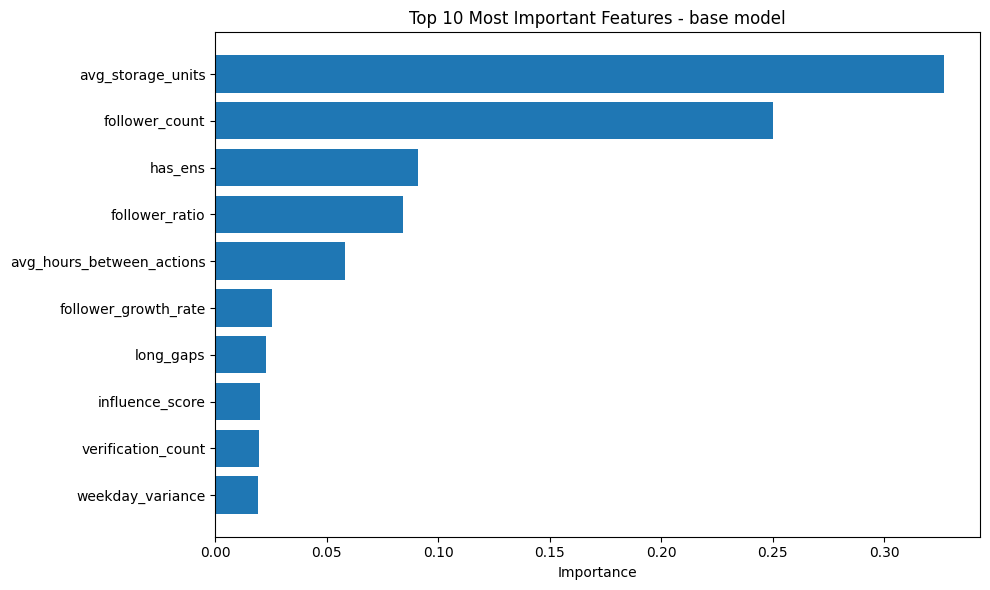

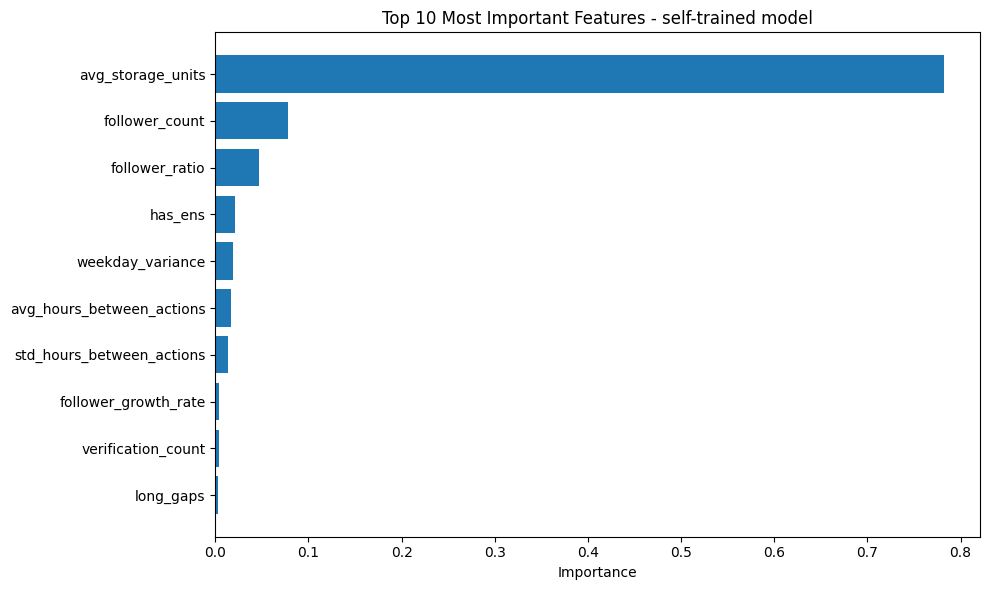

In [24]:
import matplotlib.pyplot as plt

def plot_top_10_most_important_features(model,feature_names, name=""):

    # Method 2: Using feature_importances_ attribute
    importances = model.feature_importances_

    # Create dataframe for easier sorting
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values('importance', ascending=True)

    # To show only top 10 features
    top_10 = importance_df.tail(10)  # Get last 10 rows
    plt.figure(figsize=(10, 6))
    plt.barh(top_10['feature'], top_10['importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Most Important Features - {name}')
    plt.tight_layout()
    plt.show()

plot_top_10_most_important_features(model,feature_names, name="base model")
plot_top_10_most_important_features(self_training_classifier.base_estimator_,feature_names, name="self-trained model")


In [25]:
from lightgbm import LGBMClassifier

# Self training
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

base_classifier = LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced')

    
# Create self-training classifier
self_training_classifier = SelfTrainingClassifier(
    base_classifier,
    threshold=0.9,
    verbose=True
)

df_unlabeled = df[~non_null_mask]

X_unlabeled = df_unlabeled.drop(['fid','bot'],axis=1)
y_unlabeled = df_unlabeled['bot'].fillna(-1).to_numpy().ravel()
fids_unlabeled = df_unlabeled['fid'].to_numpy().ravel()

x_self_training = np.concat([X_train,X_unlabeled])
y_self_training = np.concat([y_train,y_unlabeled])

# Fit the model
self_training_classifier.fit(x_self_training, y_self_training)

# Make predictions
y_pred_proba = self_training_classifier.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC Score: {auc_score:.4f}")

[LightGBM] [Info] Number of positive: 3209, number of negative: 154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4011
[LightGBM] [Info] Number of data points in the train set: 3363, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
End of iteration 1, added 311211 new labels.
[LightGBM] [Info] Number of positive: 312195, number of negative: 2379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4690
[LightGBM] [Info] Number of data points in the train set: 314574, number

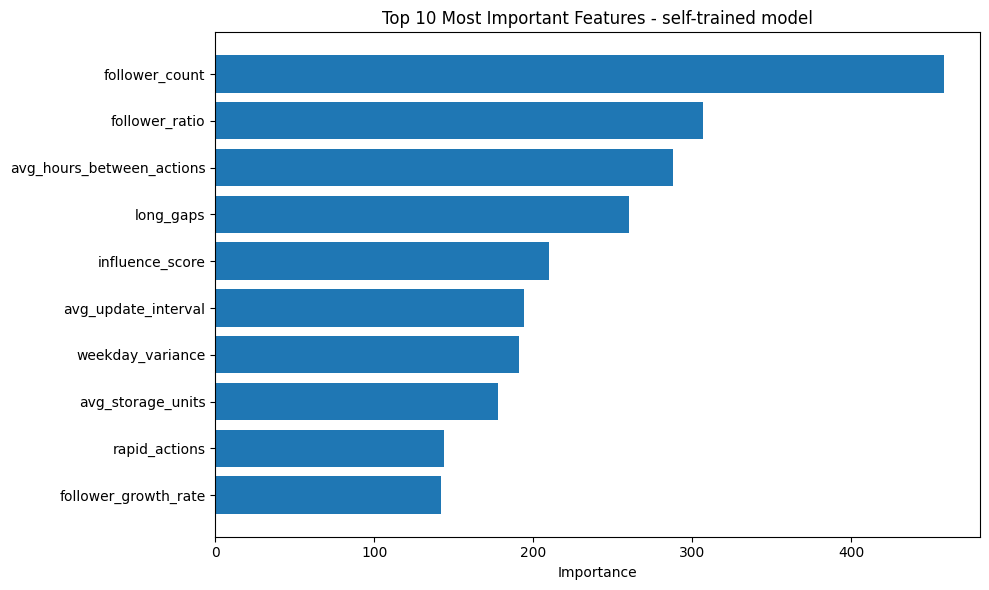

In [26]:
plot_top_10_most_important_features(self_training_classifier.base_estimator_,feature_names, name="self-trained model")

In [27]:
self_trained_bot_pctg = self_training_classifier.predict(df.drop(["fid","bot"],axis=1)).sum() / len(df)
print(f"Bot predictions in self-trained model: {100*self_trained_bot_pctg:.2f}%")

/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


Bot predictions in self-trained model: 98.22%


In [31]:
from sklearn.ensemble import RandomForestClassifier

base_classifier = RandomForestClassifier(n_jobs=-1, n_estimators=100,max_depth=4,random_state=42, class_weight='balanced')
    
# Create self-training classifier
self_training_classifier = SelfTrainingClassifier(
    base_classifier,
    threshold=0.9,
    verbose=True
)

df_unlabeled = df[~non_null_mask]

X_unlabeled = df_unlabeled.drop(['fid','bot'],axis=1)
y_unlabeled = df_unlabeled['bot'].fillna(-1).to_numpy().ravel()
fids_unlabeled = df_unlabeled['fid'].to_numpy().ravel()

x_self_training = np.concat([X_train,X_unlabeled])
y_self_training = np.concat([y_train,y_unlabeled])

# Fit the model
self_training_classifier.fit(x_self_training, y_self_training)

# Make predictions
y_pred_proba = self_training_classifier.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC Score: {auc_score:.4f}")

End of iteration 1, added 182925 new labels.
End of iteration 2, added 37841 new labels.
End of iteration 3, added 11918 new labels.
End of iteration 4, added 22028 new labels.
End of iteration 5, added 9010 new labels.
End of iteration 6, added 3181 new labels.
End of iteration 7, added 2662 new labels.
End of iteration 8, added 755 new labels.
End of iteration 9, added 300 new labels.
End of iteration 10, added 124 new labels.
Test AUC Score: 0.8832


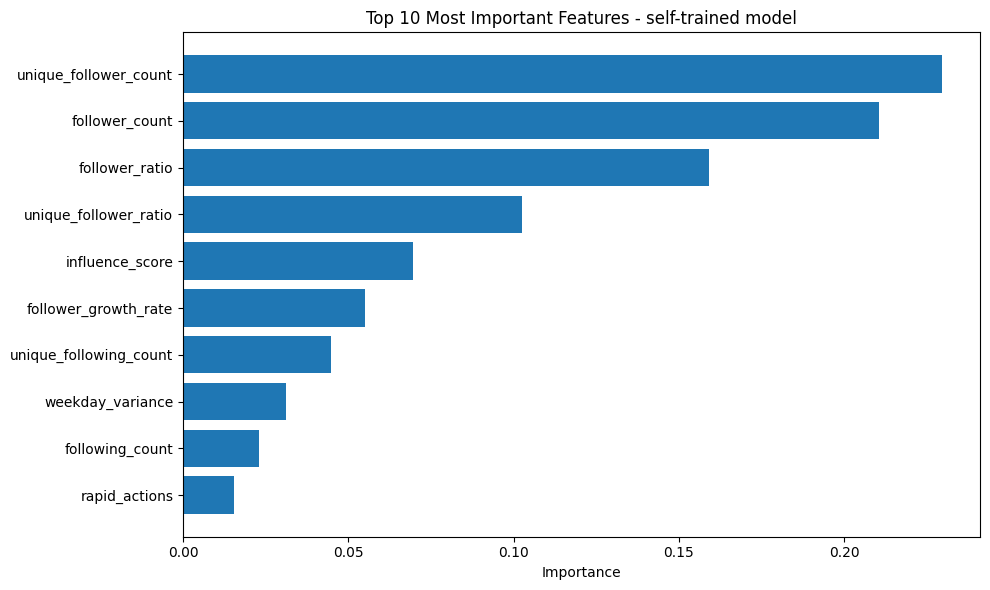

In [33]:
plot_top_10_most_important_features(self_training_classifier.base_estimator_,feature_names, name="self-trained model")

In [32]:
self_trained_bot_pctg = self_training_classifier.predict(df.drop(["fid","bot"],axis=1)).sum() / len(df)
print(f"Bot predictions in self-trained model: {100*self_trained_bot_pctg:.2f}%")

Bot predictions in self-trained model: 86.94%


/Users/jean/Library/Caches/pypoetry/virtualenvs/farcaster-social-graph-notebooks-_gupmy54-py3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelfTrainingClassifier was fitted without feature names
  warnings.warn(


In [81]:
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
import joblib
import json
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import roc_auc_score

def random_params(name):
    if name == "rf":
        return {
            'base_estimator__n_estimators': random.choice(list(range(50, 301, 50))),
            'base_estimator__max_depth': random.choice(list(range(3, 11))),
            'base_estimator__min_samples_split': random.choice([2, 5, 10, 20]),
            'base_estimator__min_samples_leaf': random.choice([1, 2, 4, 8]),
            'base_estimator__max_features': random.choice(['sqrt', 'log2', None]),
            'threshold': random.choice(np.arange(0.7, 1.0, 0.05).tolist())
        }
    if name == "lgbm":
        return {
            'base_estimator__n_estimators': random.choice(list(range(50, 301, 50))),
            'base_estimator__max_depth': random.choice(list(range(3, 11))),
            'base_estimator__num_leaves': random.choice([15, 31, 63, 127]),
            'base_estimator__learning_rate': random.choice([0.01, 0.05, 0.1]),
            'base_estimator__min_child_samples': random.choice([5, 10, 20, 50]),
            'base_estimator__subsample': random.choice([0.6, 0.7, 0.8, 0.9, 1.0]),
            'base_estimator__colsample_bytree': random.choice([0.6, 0.7, 0.8, 0.9, 1.0]),
            'threshold': random.choice(np.arange(0.7, 1.0, 0.05).tolist())
        }
    if name == "xgboost":
        return {
            'base_estimator__n_estimators': random.choice(list(range(50, 301, 50))),
            'base_estimator__max_depth': random.choice(list(range(3, 11))),
            'base_estimator__learning_rate': random.choice([0.01, 0.05, 0.1]),
            'base_estimator__min_child_weight': random.choice([1, 3, 5, 7]),
            'base_estimator__subsample': random.choice([0.6, 0.7, 0.8, 0.9, 1.0]),
            'base_estimator__colsample_bytree': random.choice([0.6, 0.7, 0.8, 0.9, 1.0]),
            'base_estimator__gamma': random.choice([0, 0.1, 0.2, 0.3, 0.4]),
            'threshold': random.choice(np.arange(0.7, 1.0, 0.05).tolist())
        }
    return

def get_model(name,params):
    if name == "rf":
        return RandomForestClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight='balanced',
            n_estimators=params['base_estimator__n_estimators'],
            max_depth=params['base_estimator__max_depth'],
            min_samples_split=params['base_estimator__min_samples_split'],
            min_samples_leaf=params['base_estimator__min_samples_leaf'],
            max_features=params['base_estimator__max_features']
        )
    if name == "lgbm":
        return LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            n_estimators=params['base_estimator__n_estimators'],
            max_depth=params['base_estimator__max_depth'],
            num_leaves=params['base_estimator__num_leaves'],
            learning_rate=params['base_estimator__learning_rate'],
            min_child_samples=params['base_estimator__min_child_samples'],
            subsample=params['base_estimator__subsample'],
            colsample_bytree=params['base_estimator__colsample_bytree'],
            class_weight='balanced'
        )
    if name == "xgboost":
        return XGBClassifier(
            n_jobs=-1,
            random_state=42,
            n_estimators=params['base_estimator__n_estimators'],
            max_depth=params['base_estimator__max_depth'],
            learning_rate=params['base_estimator__learning_rate'],
            min_child_weight=params['base_estimator__min_child_weight'],
            subsample=params['base_estimator__subsample'],
            colsample_bytree=params['base_estimator__colsample_bytree'],
            gamma=params['base_estimator__gamma'],
            eval_metric='auc',
            scale_pos_weight=scale_pos_weight
        )

def random_search(name, n_iterations=20):
    # Set random seed for reproducibility
    random.seed(42)

    # Keep track of best model and score
    best_score = 0
    best_params = None
    best_model = None
    all_results = []

    for i in range(n_iterations):
        params = random_params(name)

        clf = SelfTrainingClassifier(
            get_model(name,params),
            threshold=params['threshold'],
            verbose=False,
            max_iter=5
        )
        
        try:
            # Fit on training data
            clf.fit(x_self_training, y_self_training)
            
            # Evaluate on validation set
            val_score = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
            print(f"Iteration {i+1}/{n_iterations}")
            print(f"Parameters: {params}")
            print(f"Validation Score: {val_score:.4f}\n")
            
            # Store all results
            all_results.append({
                'params': params,
                'val_score': val_score
            })
            
            # Update best if better
            if val_score > best_score:
                best_score = val_score
                best_params = params
                best_model = clf

            
                
        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}\n")
            continue

    test_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

    metrics = {
        'best_validation_score': float(best_score),
        'test_score': float(test_score),
        'n_iterations': n_iterations
    }
    # Finally, evaluate the best model on the test set
    test_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    print("\nBest validation score:", best_score)
    print("\nBest params:", best_params)
    print("Test score with best model:", test_score)

    return best_model, best_params, metrics

def save_model_artifacts(model, params, model_name, logs_path, metrics):
    """Save model, parameters, and metrics"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = os.path.join(logs_path, f"{model_name}_{timestamp}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(model_dir, f"{model_name}_model.joblib")
    joblib.dump(model, model_path)
    
    # Save parameters
    params_path = os.path.join(model_dir, f"{model_name}_params.json")
    with open(params_path, 'w') as f:
        json.dump(params, f, indent=4)
    
    # Save metrics
    metrics_path = os.path.join(model_dir, f"{model_name}_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    return model_dir

# Main execution
logs_path = os.path.join(DATA_PATH, "../notebooks/logs")
os.makedirs(logs_path, exist_ok=True)

best_models = {}
best_params = {}
model_paths = {}

for model_name in ["xgboost", "lgbm", "rf"]:
    print(f"\nPerforming random search for {model_name}...")
    best_model, params, metrics = random_search(model_name, n_iterations=20)
    
    best_models[model_name] = best_model
    best_params[model_name] = params
    
    # Save model artifacts
    model_dir = save_model_artifacts(
        best_model,
        params,
        model_name,
        logs_path,
        metrics
    )
    model_paths[model_name] = model_dir
    print(f"Model artifacts saved in: {model_dir}")

print(best_params)



Performing random search for xgboost...
Iteration 1/20
Parameters: {'base_estimator__n_estimators': 300, 'base_estimator__max_depth': 4, 'base_estimator__learning_rate': 0.01, 'base_estimator__min_child_weight': 5, 'base_estimator__subsample': 0.7, 'base_estimator__colsample_bytree': 0.7, 'base_estimator__gamma': 0.1, 'threshold': 0.9500000000000002}
Validation Score: 0.9907

Iteration 2/20
Parameters: {'base_estimator__n_estimators': 50, 'base_estimator__max_depth': 4, 'base_estimator__learning_rate': 0.1, 'base_estimator__min_child_weight': 7, 'base_estimator__subsample': 0.6, 'base_estimator__colsample_bytree': 0.6, 'base_estimator__gamma': 0, 'threshold': 0.75}
Validation Score: 0.9839

Iteration 3/20
Parameters: {'base_estimator__n_estimators': 100, 'base_estimator__max_depth': 3, 'base_estimator__learning_rate': 0.1, 'base_estimator__min_child_weight': 3, 'base_estimator__subsample': 1.0, 'base_estimator__colsample_bytree': 0.9, 'base_estimator__gamma': 0.1, 'threshold': 0.85000

In [ ]:
models = best_models.copy()
models.keys()

dict_keys(['xgboost', 'lgbm', 'rf'])

In [ ]:

most_important_features = []
for model in models.values():
  importances = model.base_estimator_.feature_importances_

  # Create dataframe for easier sorting
  importance_df = pd.DataFrame({
      'feature': feature_names,
      'importance': importances
  })

  # Sort by importance
  importance_df = importance_df.sort_values('importance', ascending=True)

  top_10 = importance_df.tail(10)["feature"].to_list()

  most_important_features += top_10

most_important_features = list(set(most_important_features))

In [90]:
most_important_features

['weekday_variance',
 'total_activity',
 'unique_follower_count',
 'engagement_rate',
 'avg_hours_between_actions',
 'influence_score',
 'follower_ratio',
 'max_storage_units',
 'unique_follower_ratio',
 'follower_growth_rate',
 'std_hours_between_actions',
 'avg_storage_units',
 'long_gaps',
 'avg_update_interval',
 'follower_count']

In [91]:
print("Non relevant features:\n")
for feature in feature_names:
  if feature not in most_important_features:
    print(feature)

Non relevant features:

has_ens
has_bio
has_avatar
verification_count
has_display_name
following_count
unique_following_count
rapid_actions
power_reply_count
power_mentions_count
hour_diversity
weekday_diversity
storage_update_count
profile_update_consistency
total_updates
avg_hours_between_verifications
std_hours_between_verifications
rapid_verifications
avg_hours_between_platform_verifs
std_hours_between_platform_verifs


In [ ]:
def load_data(name,logs_path):

  return best_params

In [131]:
def load_empty_base_model(name, logs_path):
    """
    Load an empty model with the most recent parameters from logs
    
    Args:
        name (str): Model name ('rf', 'lgbm', or 'xgboost')
        logs_path (str): Path to the logs directory
        scale_pos_weight (float): Scale positive weight parameter for XGBoost
        
    Returns:
        model: An empty model instance with the most recent parameters
    """
    # Get all directories for this model type
    model_dirs = [d for d in os.listdir(logs_path) if d.startswith(name + "_")]
    
    if not model_dirs:
        raise ValueError(f"No logs found for model type {name}")
    
    # Sort directories by timestamp (newest first)
    model_dirs.sort(reverse=True)
    latest_dir = model_dirs[0]
    
    # Load parameters from the most recent run
    params_file = os.path.join(logs_path, latest_dir, f"{name}_params.json")
    
    if not os.path.exists(params_file):
        raise FileNotFoundError(f"Parameters file not found in {latest_dir}")
    
    with open(params_file, 'r') as f:
        params = json.load(f)
    
    # Remove 'base_estimator__' prefix from parameter names
    clean_params = {k.replace('base_estimator__', ''): v for k, v in params.items() 
                   if k.startswith('base_estimator__')}
    
    # Create and return the appropriate model
    if name == "rf":
        return RandomForestClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight='balanced',
            **clean_params
        )
    elif name == "lgbm":
        return LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight='balanced',
            verbose=-1,
            **clean_params
        )
    elif name == "xgboost":
        return XGBClassifier(
            n_jobs=-1,
            random_state=42,
            eval_metric='auc',
            scale_pos_weight=scale_pos_weight,
            **clean_params
        )
    else:
        raise ValueError(f"Unsupported model type: {name}")

def load_empty_self_training_model(name, logs_path, scale_pos_weight=1.0):
    """
    Load an empty SelfTrainingClassifier with the most recent parameters from logs
    
    Args:
        name (str): Model name ('rf', 'lgbm', or 'xgboost')
        logs_path (str): Path to the logs directory
        scale_pos_weight (float): Scale positive weight parameter for XGBoost
        
    Returns:
        model: An empty SelfTrainingClassifier instance with the most recent parameters
    """
    # Get all directories for this model type
    model_dirs = [d for d in os.listdir(logs_path) if d.startswith(name + "_")]
    
    if not model_dirs:
        raise ValueError(f"No logs found for model type {name}")
    
    # Sort directories by timestamp (newest first)
    model_dirs.sort(reverse=True)
    latest_dir = model_dirs[0]
    
    # Load parameters from the most recent run
    params_file = os.path.join(logs_path, latest_dir, f"{name}_params.json")
    
    if not os.path.exists(params_file):
        raise FileNotFoundError(f"Parameters file not found in {latest_dir}")
    
    with open(params_file, 'r') as f:
        params = json.load(f)
    
    # Remove 'base_estimator__' prefix from parameter names
    clean_params = {k.replace('base_estimator__', ''): v for k, v in params.items() 
                   if k.startswith('base_estimator__')}
    
    # Get threshold parameter for SelfTrainingClassifier
    threshold = params.get('threshold', 0.75)  # Default to 0.75 if not found
    
    # Create base model
    if name == "rf":
        base_model = RandomForestClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight='balanced',
            **clean_params
        )
    elif name == "lgbm":
        base_model = LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight='balanced',
            verbose=-1,
            **clean_params
        )
    elif name == "xgboost":
        base_model = XGBClassifier(
            n_jobs=-1,
            random_state=42,
            eval_metric='auc',
            scale_pos_weight=scale_pos_weight,
            **clean_params
        )
    else:
        raise ValueError(f"Unsupported model type: {name}")
    
    # Create and return SelfTrainingClassifier
    return SelfTrainingClassifier(
        base_model,
        threshold=threshold,
        verbose=False,
        max_iter=5
    )

def load_latest_metrics(name, logs_path):
    """
    Load metrics from the most recent run for a specific model type
    
    Args:
        name (str): Model name ('rf', 'lgbm', or 'xgboost')
        logs_path (str): Path to the logs directory
        
    Returns:
        dict: Dictionary containing metrics and metadata
    """
    # Get all directories for this model type
    model_dirs = [d for d in os.listdir(logs_path) if d.startswith(name + "_")]
    
    if not model_dirs:
        raise ValueError(f"No logs found for model type {name}")
    
    # Sort directories by timestamp (newest first)
    model_dirs.sort(reverse=True)
    latest_dir = model_dirs[0]
    
    # Load metrics from the most recent run
    metrics_file = os.path.join(logs_path, latest_dir, f"{name}_metrics.json")
    params_file = os.path.join(logs_path, latest_dir, f"{name}_params.json")
    
    if not os.path.exists(metrics_file):
        raise FileNotFoundError(f"Metrics file not found in {latest_dir}")
        
    if not os.path.exists(params_file):
        raise FileNotFoundError(f"Parameters file not found in {latest_dir}")
    
    # Extract timestamp from directory name
    timestamp = latest_dir.replace(f"{name}_", "")
    
    with open(metrics_file, 'r') as f:
        metrics = json.load(f)
    
    return metrics

def filter_features(X_train, feature_names, allowed_features):
    """
    Filter X_train to keep only allowed features
    
    Args:
        X_train (np.array): Array with all features
        feature_names (list): Names of features matching X_train columns
        forbidden_features (list): Features to exclude
        
    Returns:
        np.array: Filtered X_train with only allowed features
    """
    # Convert inputs to numpy arrays if they aren't already
    X_train = np.array(X_train)
    feature_names = np.array(feature_names)
    
    # Create boolean mask for allowed features
    allowed_mask = np.isin(feature_names, allowed_features)
    
    # Get allowed feature names (for debugging/logging if needed)
    allowed_features = feature_names[allowed_mask]
    
    # Return filtered X_train using the mask
    return X_train[:, allowed_mask]

### 1. Does self-training make difference?

In [130]:
for model_name,model in models.items():
  # 1. Get empty base model with best params
  base_model = load_empty_base_model(model_name,logs_path)
  self_training_score = load_latest_metrics(model_name,logs_path)["test_score"]

  # 2. Train without self-training
  base_model.fit(X_train[0:len(y_train[y_train!=-1])],y_train[y_train!=-1])
  base_model_score = roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1])

  # 3. Compare with result on self-training
  print(f"Model: {model_name}")
  print(f"Score without self-training: {self_training_score:.4f}")
  print(f"Score with self-training: {base_model_score:.4f}")
  print("")

Model: xgboost
Score without self-training: 0.9575
Score with self-training: 0.9404

Model: lgbm
Score without self-training: 0.9273
Score with self-training: 0.9564

Model: rf
Score without self-training: 0.9424
Score with self-training: 0.9457



### 2. Does non-relevant features make difference?

In [134]:
for model_name,model in models.items():
  # 1. Get best params
  self_training_without_params_model = load_empty_self_training_model(model_name,logs_path)
  self_training_score = load_latest_metrics(model_name,logs_path)["test_score"]

  # 2. Train with self-training without non-relevant-features

  X_train_filtered = filter_features(x_self_training, feature_names, most_important_features)
  X_test_filtered = filter_features(X_test, feature_names, most_important_features)

  self_training_without_params_model.fit(X_train_filtered,y_self_training)
  self_training_without_params_score = roc_auc_score(y_test, self_training_without_params_model.predict_proba(X_test_filtered)[:, 1])

  # 3. Compare with result on self-training

  print(f"Model: {model_name}")
  print(f"Score without non-important features: {self_training_without_params_score:.4f}")
  print(f"Score with non-important features: {self_training_score:.4f}")
  print("")
  

Model: xgboost
Score without non-important features: 0.9225
Score with non-important features: 0.9575

Model: lgbm
Score without non-important features: 0.9326
Score with non-important features: 0.9273

Model: rf
Score without non-important features: 0.9498
Score with non-important features: 0.9424



In [ ]:
most_important_features

['weekday_variance',
 'total_activity',
 'unique_follower_count',
 'engagement_rate',
 'avg_hours_between_actions',
 'influence_score',
 'follower_ratio',
 'max_storage_units',
 'unique_follower_ratio',
 'follower_growth_rate',
 'std_hours_between_actions',
 'avg_storage_units',
 'long_gaps',
 'avg_update_interval',
 'follower_count']

### Conclusions

- To use self-training demonstrated to not increse the models scores significantly
- It's possible to filter some great amount of features (approx. 70%) keeping the same performance